In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, naive_bayes
import numpy as np
import seaborn as sns
import re
from scipy.stats import chi2_contingency
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler
import graphviz
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import optuna
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset Loading

In [3]:
SpookyTrain = pd.read_csv('Data/spooky-author-identification/train.csv')
#SpookyTest = pd.read_csv('Data/spooky-author-identification/test.csv')

SpookyTrain.head()
#SpookyTest.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# Print data type of each column
categorical_amount = 0
continuous_amount = 0
for column, dtype in SpookyTrain.dtypes.items():
    group = 'continuous' if dtype in ['int64', 'float64'] else 'categorical'
    if(group == 'categorical'):
        categorical_amount += 1
    else:
        continuous_amount += 1
    print(f"Column {column} has data type {dtype}/{group}")
print(f"Total categorical columns: {categorical_amount}")
print(f"Total continuous columns: {continuous_amount}")
#No misclassify column types
#We have more categorical columns than continuous columns

Column id has data type object/categorical
Column text has data type object/categorical
Column author has data type object/categorical
Total categorical columns: 3
Total continuous columns: 0


# Feature Engineering

TfidfVectorizer training done
200
Starting TruncatedSVD
n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15
n_components = 16
n_components = 17
n_components = 18
n_components = 19
n_components = 20
n_components = 21
n_components = 22
n_components = 23
n_components = 24
n_components = 25
n_components = 26
n_components = 27
n_components = 28
n_components = 29
n_components = 30
n_components = 31
n_components = 32
n_components = 33
n_components = 34
n_components = 35
n_components = 36
n_components = 37
n_components = 38
n_components = 39
n_components = 40
n_components = 41
n_components = 42
n_components = 43
n_components = 44
n_components = 45
n_components = 46
n_components = 47
n_components = 48
n_components = 49
n_components = 50
n_components = 51
n_components = 52
n_components = 53

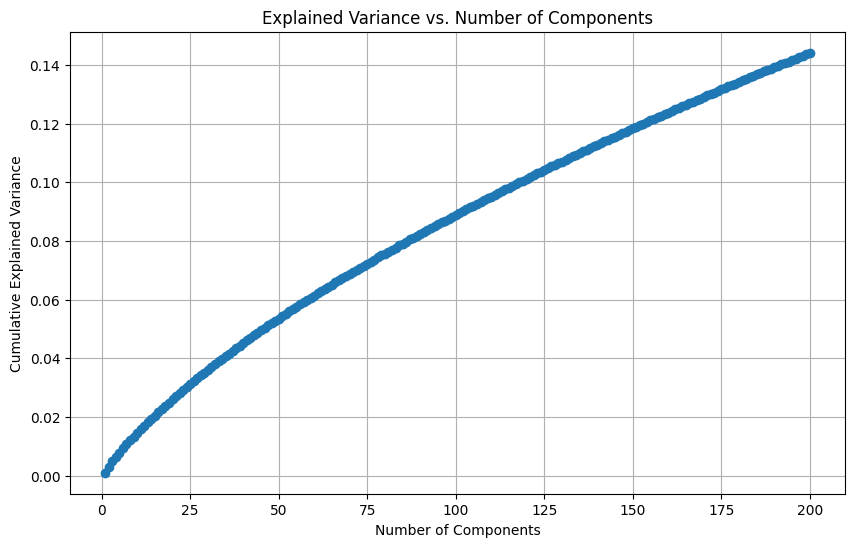

In [27]:
#trial on elbow method to find the best num_components of TruncatedSVD
tfidf_transformer = TfidfVectorizer(stop_words = "english")
tfidf_transformer.fit(SpookyTrain['text'])
Train_tfidf = tfidf_transformer.transform(x for x in SpookyTrain['text'])
#Test_tfidf = SpookyTest['text'].apply(lambda x: tfidf_transformer.transform([x]))
print("TfidfVectorizer training done")
#TruncatedSVD with 400 components
max_components = 200  # minimum dimension minus one
print(max_components)
print("Starting TruncatedSVD")
explained_variances = []
for n_components in range(1, max_components+1):
    print(f"n_components = {n_components}")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(Train_tfidf)
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(10,6))
plt.plot(range(1, max_components+1), explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()
#Even with high number of components, the explained variance is still low
#We will use 200 components for TruncatedSVD

In [29]:
#Try to extract several variables from text
#simple features
def splitSentenceInPredefinedSeparator(x):
    separators = [',', ' ', '.']
    for separator in separators:
        x = x.replace(separator, ' ')
    return str(x).split()

#Count number of words
def numberOfWords(x):
    #return number of words that has been splitted including with ',', '.', ' '
    return len(splitSentenceInPredefinedSeparator(x))
SpookyTrain['num-words'] = SpookyTrain['text'].apply(lambda x: numberOfWords(x))
#SpookyTest['num-words'] = SpookyTest['text'].apply(lambda x: numberOfWords(x))
#Count number of unique words
def uniqueWords(x):
    #return number of unique words that has been splitted including with ',', '.', ' '
    return len(set(splitSentenceInPredefinedSeparator(x)))
SpookyTrain['num-unique-words'] = SpookyTrain['text'].apply(lambda x: uniqueWords(x))
#SpookyTest['num-unique-words'] = SpookyTest['text'].apply(lambda x: uniqueWords(x))
#Count number of punctuations
SpookyTrain['num-punctuations'] = SpookyTrain['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#SpookyTest['num-punctuations'] = SpookyTest['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#UniqueWordRatio
SpookyTrain['unique-word-ratio'] = SpookyTrain['num-unique-words'] / SpookyTrain['num-words']
#SpookyTest['unique-word-ratio'] = SpookyTest['num-unique-words'] / SpookyTest['num-words']
#PunctuationRatio
SpookyTrain['punctuation-ratio'] = SpookyTrain['num-punctuations'] / SpookyTrain['num-words']
#SpookyTest['punctuation-ratio'] = SpookyTest['num-punctuations'] / SpookyTest['num-words']
#Sentence Length
SpookyTrain['sentence-length'] = SpookyTrain['text'].apply(lambda x: len(x.split('.')))
#SpookyTest['sentence-length'] = SpookyTest['text'].apply(lambda x: len(x.split('.')))
#Number of Words beginning with capital letters (Other than first word in a sentence after period)
SpookyTrain['num-words-beginning-capital'] = SpookyTrain['text'].apply(lambda x: len([w for w in x.split() if w[0].isupper() and w[0] not in ['.', '"', "'"]]))
#SpookyTest['num-words-beginning-capital'] = SpookyTest['text'].apply(lambda x: len([w for w in x.split() if w[0].isupper() and w[0] not in ['.', '"', "'"]]))
#Count Number of Nouns, and Nouns Ratio
print("beginning noun extraction")
SpookyTrain['num-nouns'] = SpookyTrain['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['NN', 'NNP']]))
#SpookyTest['num-nouns'] = SpookyTest['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['NN', 'NNP']]))
SpookyTrain['nouns-ratio'] = SpookyTrain['num-nouns'] / SpookyTrain['num-words']
#SpookyTest['nouns-ratio'] = SpookyTest['num-nouns'] / SpookyTest['num-words']
#Count Number of Verbs, and Verbs Ratio
print("beginning verb extraction")
SpookyTrain['num-verbs'] = SpookyTrain['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
#SpookyTest['num-verbs'] = SpookyTest['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
SpookyTrain['verbs-ratio'] = SpookyTrain['num-verbs'] / SpookyTrain['num-words']
#SpookyTest['verbs-ratio'] = SpookyTest['num-verbs'] / SpookyTest['num-words']
#Count Number of Adjectives, and Adjectives Ratio
print("beginning adjective extraction")
SpookyTrain['num-adjectives'] = SpookyTrain['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']]))
#SpookyTest['num-adjectives'] = SpookyTest['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']]))
SpookyTrain['adjectives-ratio'] = SpookyTrain['num-adjectives'] / SpookyTrain['num-words']
#SpookyTest['adjectives-ratio'] = SpookyTest['num-adjectives'] / SpookyTest['num-words']
#Average Word Length
SpookyTrain['average-word-length'] = SpookyTrain['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))
#SpookyTest['average-word-length'] = SpookyTest['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))
#stopwords count
SpookyTrain['stopwords-count'] = SpookyTrain['text'].apply(lambda x: len([w for w in splitSentenceInPredefinedSeparator(x) if w.lower() in nltk.corpus.stopwords.words('english')]))
#SpookyTest['stopwords-count'] = SpookyTest['text'].apply(lambda x: len([w for w in splitSentenceInPredefinedSeparator(x) if w.lower() in nltk.corpus.stopwords.words('english')]))
SpookyTrain['Stopwords-ratio'] = SpookyTrain['stopwords-count'] / SpookyTrain['num-words']
#SpookyTest['Stopwords-ratio'] = SpookyTest['stopwords-count'] / SpookyTest['num-words']

beginning noun extraction
beginning verb extraction
beginning adjective extraction


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\Bryan/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\Bryan\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [33]:
#stopwords count
SpookyTrain['stopwords-count'] = SpookyTrain['text'].apply(lambda x: len([w for w in splitSentenceInPredefinedSeparator(x) if w.lower() in nltk.corpus.stopwords.words('english')]))
#SpookyTest['stopwords-count'] = SpookyTest['text'].apply(lambda x: len([w for w in splitSentenceInPredefinedSeparator(x) if w.lower() in nltk.corpus.stopwords.words('english')]))
SpookyTrain['Stopwords-ratio'] = SpookyTrain['stopwords-count'] / SpookyTrain['num-words']
#SpookyTest['Stopwords-ratio'] = SpookyTest['stopwords-count'] / SpookyTest['num-words']


print("Simple features extracted")

Simple features extracted
TfidfVectorizer training done


ValueError: setting an array element with a sequence.

In [34]:
#save simple features into a new csv
SpookyTrain.to_csv('Data/spooky-author-identification/Train_simple_processed.csv', index=False)

In [19]:
#scientific features
#tf-idf: term frequency-inverse document frequency which means the importance of a word in a document
#applied also with TruncatedSVD to reduce dimensionality, PCA is not good for Sparse matrix
tfidf_transformer = TfidfVectorizer(stop_words = "english")
tfidf_transformer.fit(SpookyTrain['text'])
Train_tfidf = tfidf_transformer.transform(x for x in SpookyTrain['text'])
#Test_tfidf = SpookyTest['text'].apply(lambda x: tfidf_transformer.transform([x]))
print("TfidfVectorizer training done")

ComponentsAmountTrial = [10, 20, 50, 100, 200, 400, 600, 800]
for n_components in ComponentsAmountTrial:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    Train_tfidf_svd = svd.fit_transform(Train_tfidf)
    print(f"TruncatedSVD {n_components} training done")
    #Test_tfidf_svd = svd.transform(Test_tfidf)
    train_lsa_df = pd.DataFrame(Train_tfidf_svd, columns=[f"TF-IDF-TSVD_{i}" for i in range(1, Train_tfidf_svd.shape[1] + 1)])
    train_lsa_df.to_csv(f'Data/spooky-author-identification/Train_processed_TFIDFSVD_{n_components}.csv', index=False)

TfidfVectorizer training done
TruncatedSVD 10 training done
TruncatedSVD 20 training done
TruncatedSVD 50 training done
TruncatedSVD 100 training done
TruncatedSVD 200 training done
TruncatedSVD 400 training done
TruncatedSVD 600 training done
TruncatedSVD 800 training done


In [4]:
#Semantic Analysis Using spaCy: 
nlp = spacy.load("en_core_web_md")
def get_embedding(text):
    doc = nlp(text)
    return doc.vector
Result = SpookyTrain['text'].apply(get_embedding)
print("Semantic Analysis Done")
spacy = pd.DataFrame(Result, columns=[f"Spacy_{i}" for i in range(1, Result.shape[1] + 1)])
# #save the current data to csv first for future usage
spacy.to_csv('Data/spooky-author-identification/Train_processed_Spacy.csv', index=False)

Semantic Analysis Done


IndexError: tuple index out of range

In [15]:
NumpyConverted = np.array(Result.tolist())
print(NumpyConverted)
print(NumpyConverted.shape)
spacy = pd.DataFrame(NumpyConverted, columns=[f"Spacy_{i}" for i in range(1, NumpyConverted.shape[1] + 1)])
spacy.to_csv('Data/spooky-author-identification/Train_processed_Spacy.csv', index=False)

[[-2.904947    0.2750652  -1.4426674  ... -1.6134022  -3.727517
   0.6284724 ]
 [-1.2353377   3.218455   -3.492032   ...  0.61355174 -4.2791047
   3.440444  ]
 [-1.838719   -0.38315183 -1.2139969  ... -0.5817817  -2.6674902
  -0.31523523]
 ...
 [-1.3341975   2.920346   -1.1477473  ...  2.3401186  -3.275571
   2.5534782 ]
 [ 0.05294924  0.49260318 -0.64055985 ...  1.4695622  -4.040548
   0.9395003 ]
 [-1.4307915   1.8920037  -3.5957487  ...  0.44103178 -5.0121856
   1.419166  ]]
(19579, 300)


In [17]:
#Compress Spacy with TruncatedSVD
ComponentsAmountTrial = [5, 10, 20, 50, 75, 100]
for n_components in ComponentsAmountTrial:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    Train_spacy_svd = svd.fit_transform(NumpyConverted)
    print(f"TruncatedSVD {n_components} training done")
    #Test_tfidf_svd = svd.transform(Test_tfidf)
    train_spacy_svd_df = pd.DataFrame(Train_spacy_svd, columns=[f"Spacy-TSVD_{i}" for i in range(1, Train_spacy_svd.shape[1] + 1)])
    train_spacy_svd_df.to_csv(f'Data/spooky-author-identification/Train_processed_SpacySVD_{n_components}.csv', index=False)

TruncatedSVD 5 training done
TruncatedSVD 10 training done
TruncatedSVD 20 training done
TruncatedSVD 50 training done
TruncatedSVD 75 training done
TruncatedSVD 100 training done


In [112]:
#Using Naive bayes to summarize the TF-IDF
def runMNB(Xtrain, Ytrain):
    model = naive_bayes.MultinomialNB()
    model.fit(Xtrain, Ytrain)
    return model

def runMNBWithCrossValidation(Xtrain, Ytrain):
    model = naive_bayes.MultinomialNB()
    return cross_val_score(model, Xtrain, Ytrain, cv=10, scoring='balanced_accuracy').mean()

modelMNB = runMNB(Train_tfidf, SpookyTrain['author'])
print("10 Cross Validation MNB Balanced Accuracy: ", cross_val_score(runMNB(Train_tfidf, SpookyTrain['author']), Train_tfidf, SpookyTrain['author'], cv=10, scoring='balanced_accuracy').mean())

print("Training Accuracy: ", accuracy_score(modelMNB.predict(Train_tfidf), SpookyTrain['author'])) #when using Multinomial bayes, TF-IDF gets high accuracy score

10 Cross Validation MNB Balanced Accuracy:  0.8108417092125693
Training Accuracy:  0.9095970172123193


In [86]:
#TF-IDF with MNB shows great result
#Try to combine TF-IDF with other features
print(Train_tfidf)

  (0, 23988)	0.2169636436296708
  (0, 23052)	0.3020034613752268
  (0, 19497)	0.20621425345940883
  (0, 18392)	0.20353956045559746
  (0, 16946)	0.2813134552560119
  (0, 16441)	0.197265248330551
  (0, 15882)	0.2559503341763652
  (0, 13553)	0.20311289030711904
  (0, 13253)	0.1847103415704735
  (0, 8144)	0.20529992007159278
  (0, 6830)	0.2986485567454947
  (0, 6069)	0.27424987561908626
  (0, 3675)	0.2955857687820138
  (0, 1620)	0.24073930218622366
  (0, 1269)	0.3199844499084222
  (0, 452)	0.2540972823244096
  (1, 14936)	0.45087817564810995
  (1, 13929)	0.5230718227301623
  (1, 13692)	0.41209186654388175
  (1, 9165)	0.5943778533208967
  (2, 22193)	0.16454058942293895
  (2, 20746)	0.19064169358752867
  (2, 20156)	0.5241382381730781
  (2, 19381)	0.18971316567129357
  (2, 19018)	0.2379743279900864
  :	:
  (19574, 2739)	0.4508554908732438
  (19575, 20376)	0.6074853899556912
  (19575, 12739)	0.5237677915663489
  (19575, 3794)	0.5971840599916342
  (19576, 19060)	0.19328131925017952
  (19576, 1526

# Load Dataset from Feature Engineering

In [4]:
SpookyProcessedTrain_Simple = pd.read_csv('Data/spooky-author-identification/Train_simple_processed.csv')
#load the simple variables
SpookyProcessedTrain_Simple.head()

,id,text,author,num-words,num-unique-words,num-punctuations,unique-word-ratio,punctuation-ratio,sentence-length,num-words-beginning-capital,num-nouns,nouns-ratio,num-verbs,verbs-ratio,num-adjectives,adjectives-ratio,average-word-length,stopwords-count,Stopwords-ratio
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,7,0.853659,0.170732,2,3,10,0.243902,5,0.121951,1,0.024390,4.536585,20,0.487805
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,1,1.000000,0.071429,2,1,1,0.071429,3,0.214286,0,0.000000,4.071429,8,0.571429
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,5,0.888889,0.138889,2,1,11,0.305556,4,0.111111,3,0.083333,4.444444,17,0.472222
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,4,0.941176,0.117647,2,4,10,0.294118,5,0.147059,2,0.058824,4.970588,13,0.382353
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,4,0.925926,0.148148,2,2,7,0.259259,3,0.111111,0,0.000000,5.370370,11,0.407407


In [5]:
SpookyProcessedTrain_Spacy = pd.read_csv('Data/spooky-author-identification/Train_processed_Spacy.csv')
#Also load on the SVD
SpookyProcessedTrain_Spacy_SVD_5 = pd.read_csv('Data/spooky-author-identification/Train_processed_SpacySVD_5.csv')
SpookyProcessedTrain_Spacy_SVD_10 = pd.read_csv('Data/spooky-author-identification/Train_processed_SpacySVD_10.csv')
SpookyProcessedTrain_Spacy_SVD_20 = pd.read_csv('Data/spooky-author-identification/Train_processed_SpacySVD_20.csv')
SpookyProcessedTrain_Spacy_SVD_50 = pd.read_csv('Data/spooky-author-identification/Train_processed_SpacySVD_50.csv')
SpookyProcessedTrain_Spacy_SVD_75 = pd.read_csv('Data/spooky-author-identification/Train_processed_SpacySVD_75.csv')
SpookyProcessedTrain_Spacy_SVD_100 = pd.read_csv('Data/spooky-author-identification/Train_processed_SpacySVD_100.csv')

In [6]:
#load the TF-IDF
SpookyProcessedTrain_TFIDF_SVD_10 = pd.read_csv('Data/spooky-author-identification/Train_processed_TFIDFSVD_10.csv')
SpookyProcessedTrain_TFIDF_SVD_20 = pd.read_csv('Data/spooky-author-identification/Train_processed_TFIDFSVD_20.csv')
SpookyProcessedTrain_TFIDF_SVD_50 = pd.read_csv('Data/spooky-author-identification/Train_processed_TFIDFSVD_50.csv')
SpookyProcessedTrain_TFIDF_SVD_100 = pd.read_csv('Data/spooky-author-identification/Train_processed_TFIDFSVD_100.csv')
SpookyProcessedTrain_TFIDF_SVD_200 = pd.read_csv('Data/spooky-author-identification/Train_processed_TFIDFSVD_200.csv')
SpookyProcessedTrain_TFIDF_SVD_400 = pd.read_csv('Data/spooky-author-identification/Train_processed_TFIDFSVD_400.csv')
SpookyProcessedTrain_TFIDF_SVD_600 = pd.read_csv('Data/spooky-author-identification/Train_processed_TFIDFSVD_600.csv')
SpookyProcessedTrain_TFIDF_SVD_800 = pd.read_csv('Data/spooky-author-identification/Train_processed_TFIDFSVD_800.csv')


# Exploratory Data Analysis on Simple Variables
- No Empty Values / NaN
- Only Consider Train Dataset, since no ground truth

In [35]:
categorical_amount = 0
continuous_amount = 0
for column, dtype in SpookyProcessedTrain_Simple.dtypes.items():
    group = 'continuous' if dtype in ['int64', 'float64'] else 'categorical'
    if(group == 'categorical'):
        categorical_amount += 1
    else:
        continuous_amount += 1
    print(f"Column {column} has data type {dtype}/{group}")
print(f"Total categorical columns: {categorical_amount}")
print(f"Total continuous columns: {continuous_amount}")

Column id has data type object/categorical
Column text has data type object/categorical
Column author has data type object/categorical
Column num-words has data type int64/continuous
Column num-unique-words has data type int64/continuous
Column num-punctuations has data type int64/continuous
Column unique-word-ratio has data type float64/continuous
Column punctuation-ratio has data type float64/continuous
Column sentence-length has data type int64/continuous
Column num-words-beginning-capital has data type int64/continuous
Column num-nouns has data type int64/continuous
Column nouns-ratio has data type float64/continuous
Column num-verbs has data type int64/continuous
Column verbs-ratio has data type float64/continuous
Column num-adjectives has data type int64/continuous
Column adjectives-ratio has data type float64/continuous
Column average-word-length has data type float64/continuous
Column stopwords-count has data type int64/continuous
Column Stopwords-ratio has data type float64/co

In [48]:
#function for visualization
def describe_continuous_dataset(dataframe, column, target='author'):
    #use violin plot to see the distribution of the data
    # Define figure size.
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(dataframe[column], kde = True,color='r')
    plt.title('Histogram (Distribution)')

    plt.subplot(1, 3, 2)
    sns.violinplot(data=dataframe, x=column, y=target)
    plt.title('violinplot (Distribution respect to target)')
    
    
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=dataframe[column],color = 'b')
    plt.title('Boxplot (More native approach to see distribution)')
    
    # barplot
    # plt.subplot(1, 4, 5)
    # sns.barplot(x = column, y = target, data = dataframe)   
    # plt.title('Barplot')
    
    
    plt.show()

def describe_target_dataset(dataframe, target):
    plt.figure(figsize=(20, 7))

    sns.countplot(data=dataframe, x=target, order=dataframe[target].value_counts().index)
    plt.title(f'Count of {target}')
    plt.ylabel('Count')

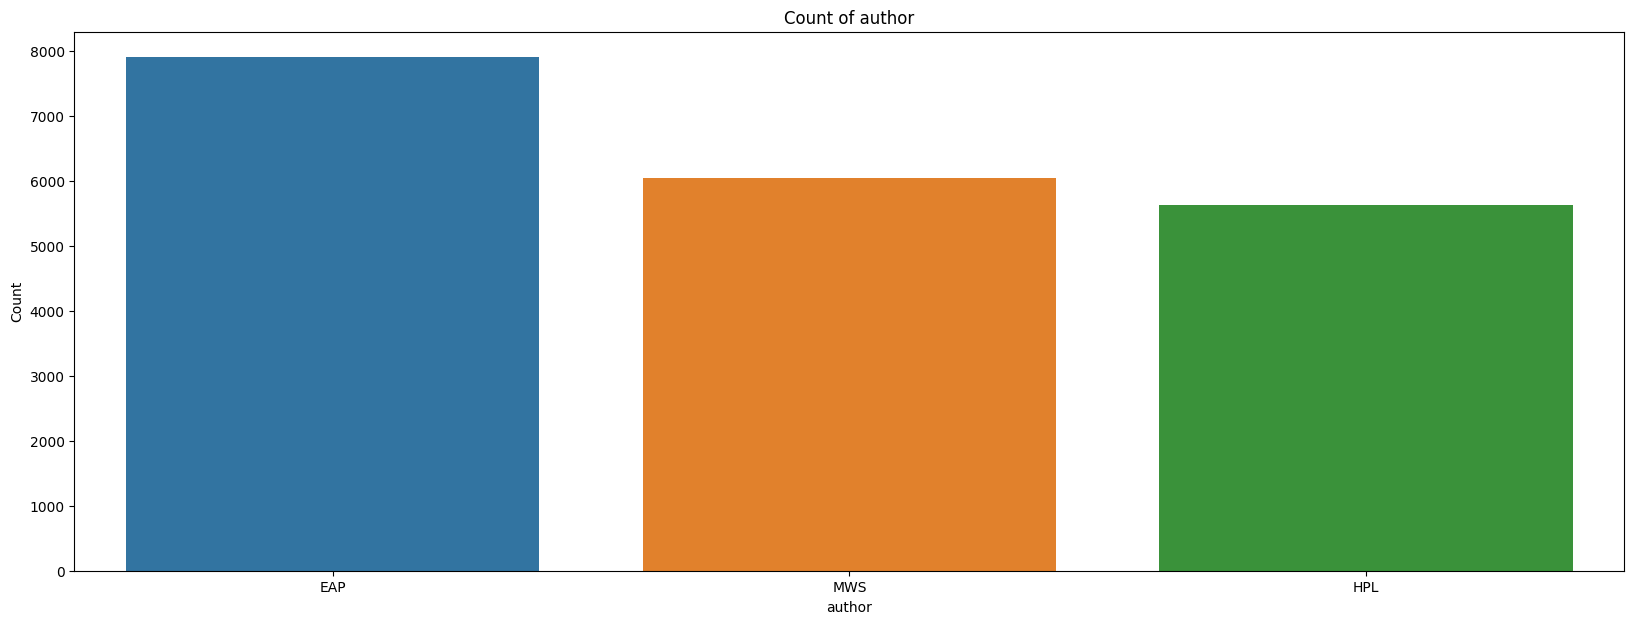

In [49]:
describe_target_dataset(SpookyProcessedTrain_Simple, 'author')

- A bit imbalanced, more in EAP, try balanced-weights later on

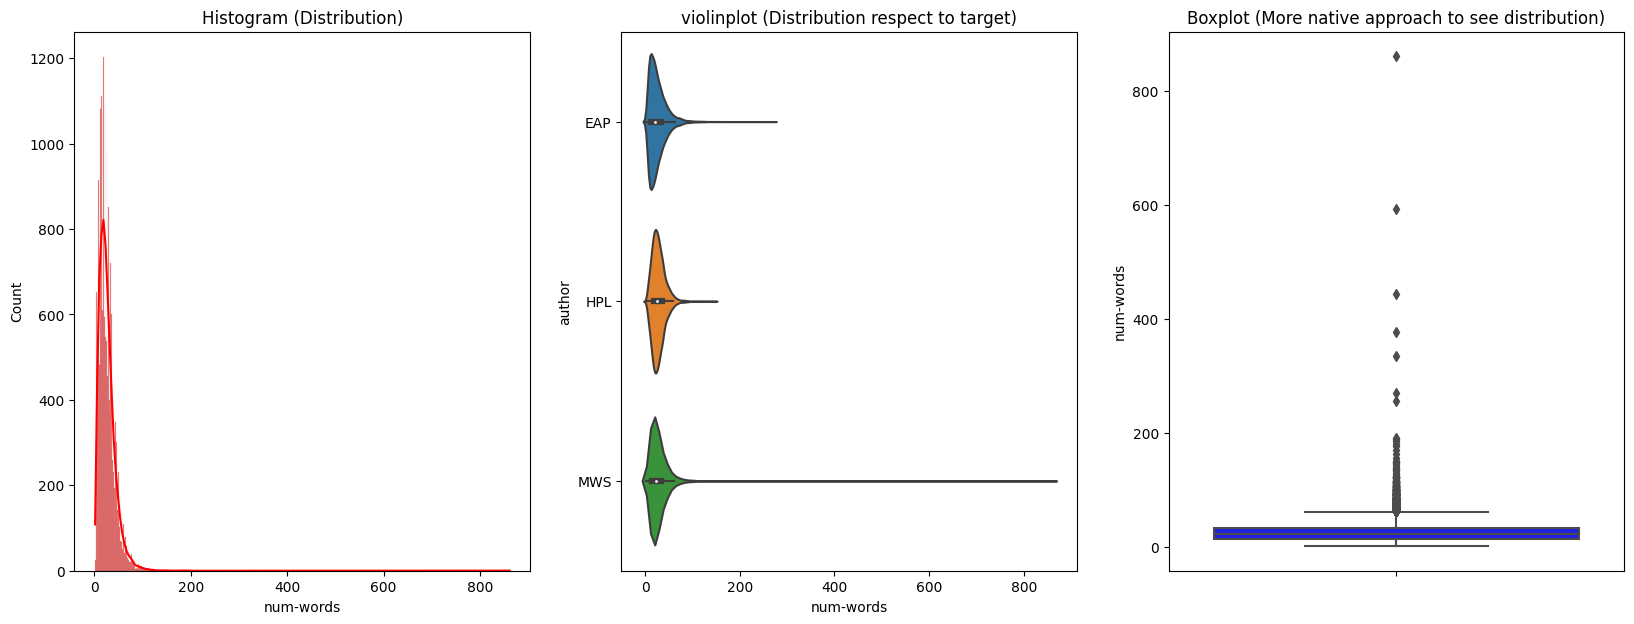

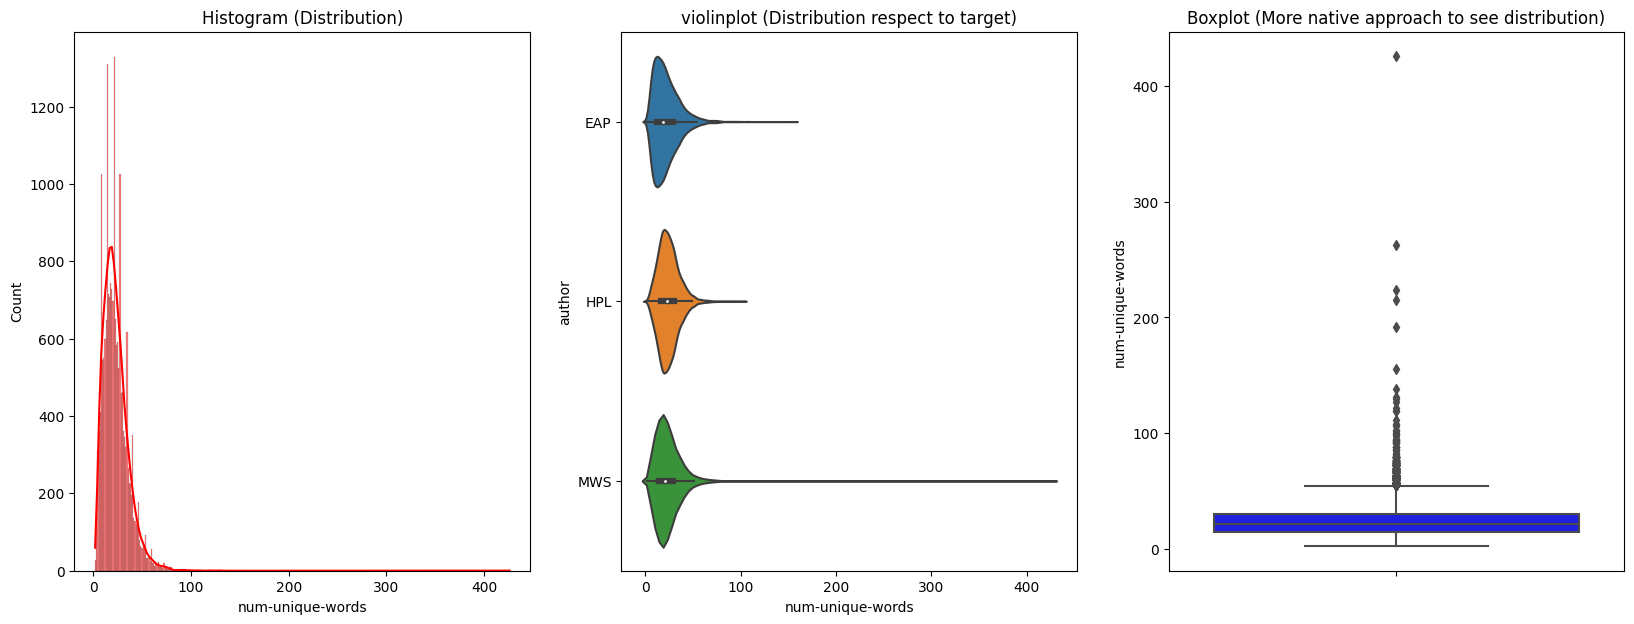

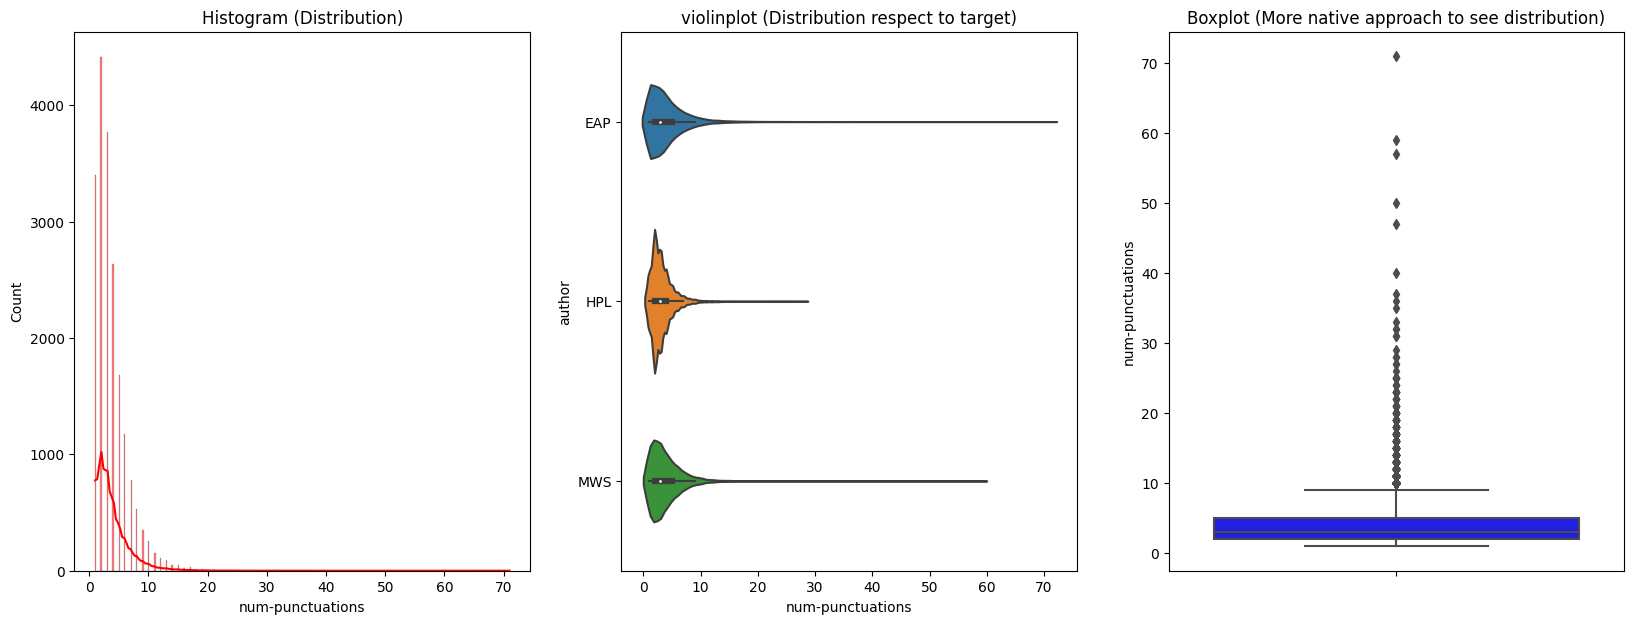

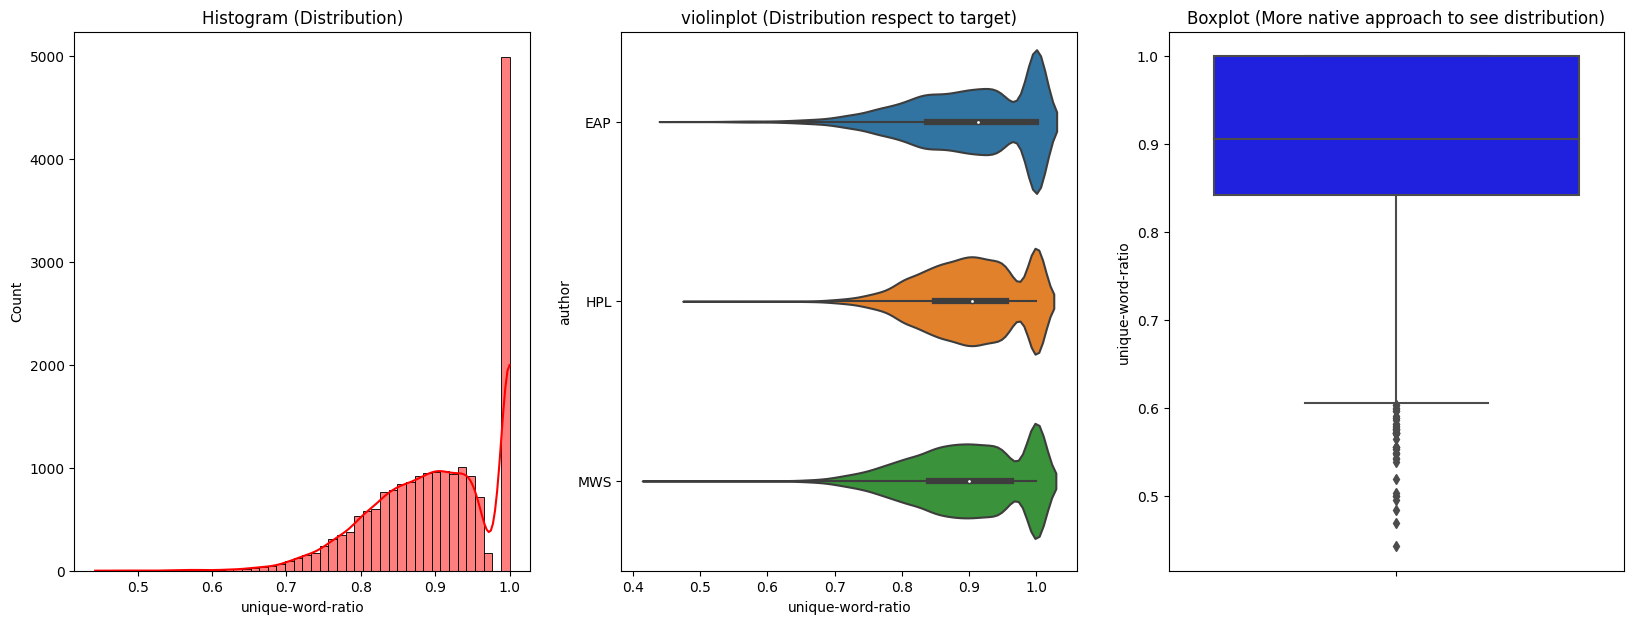

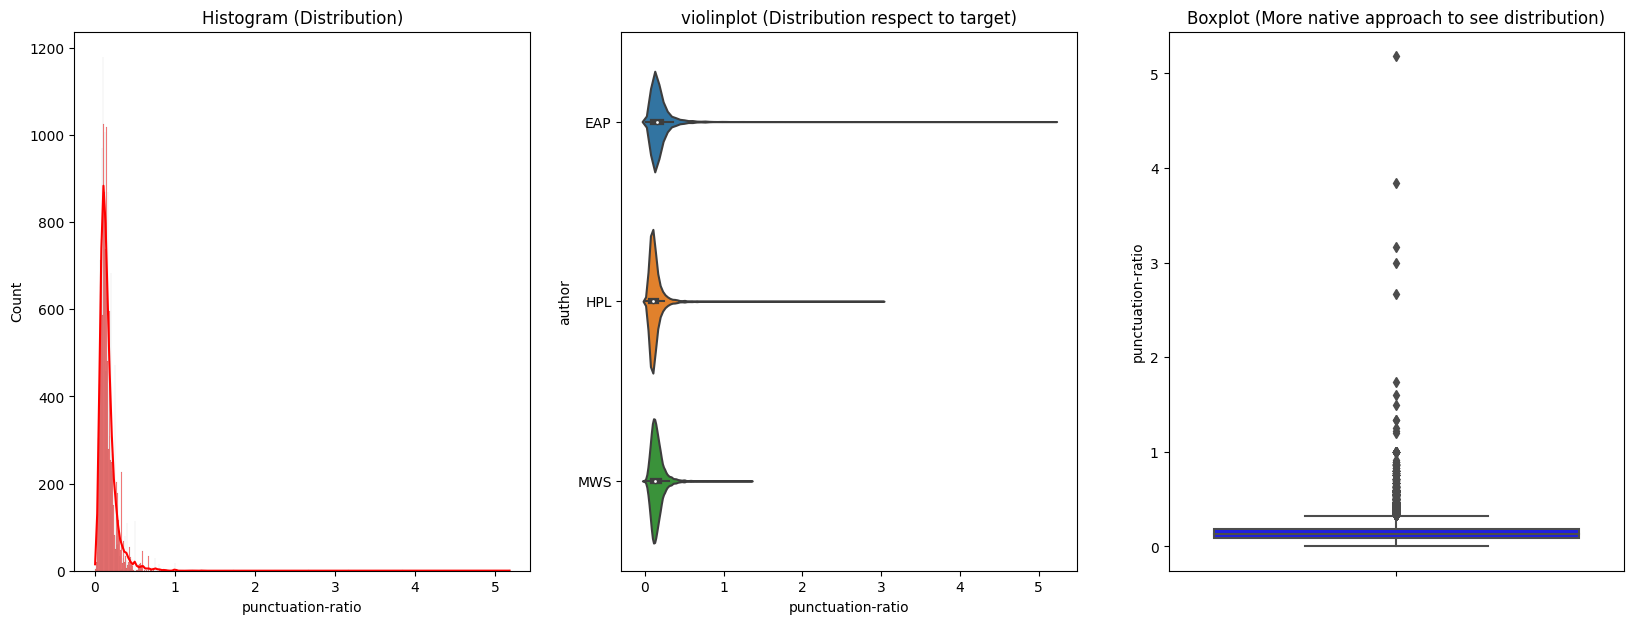

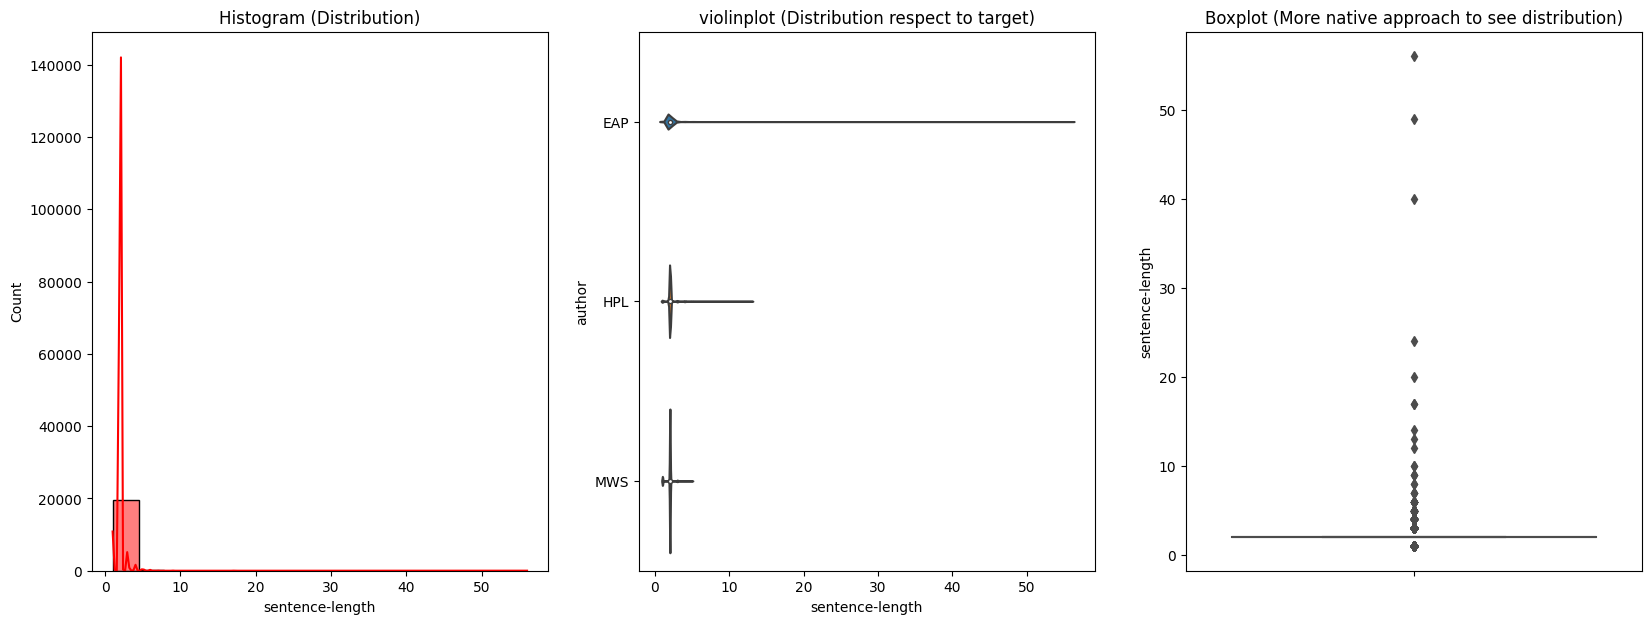

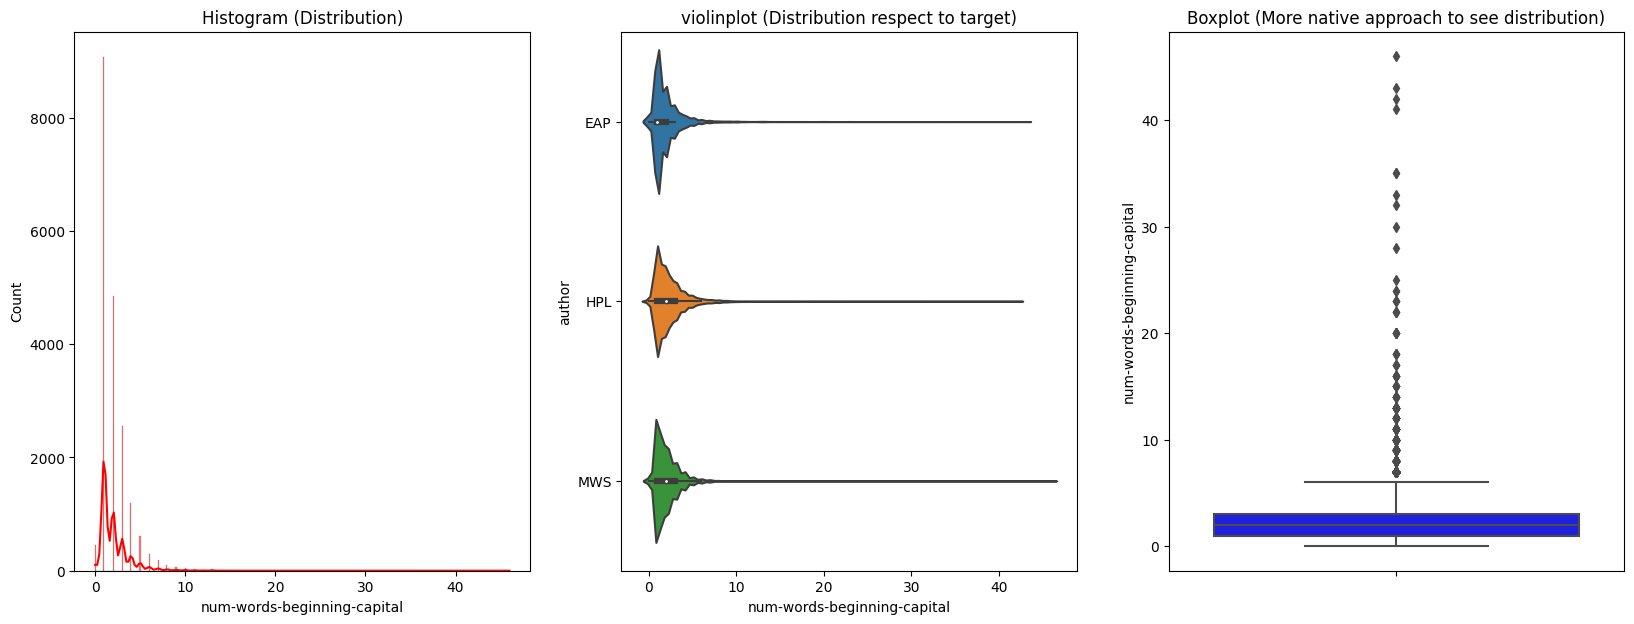

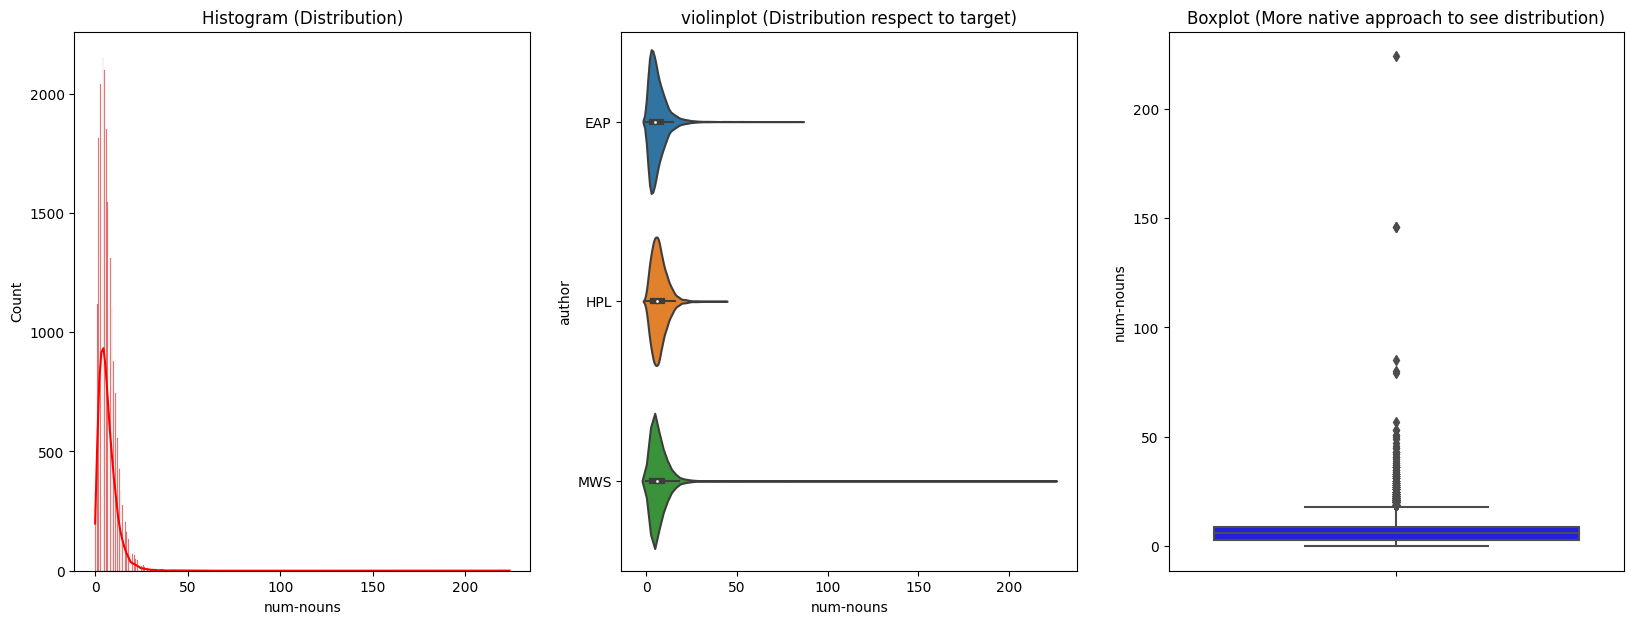

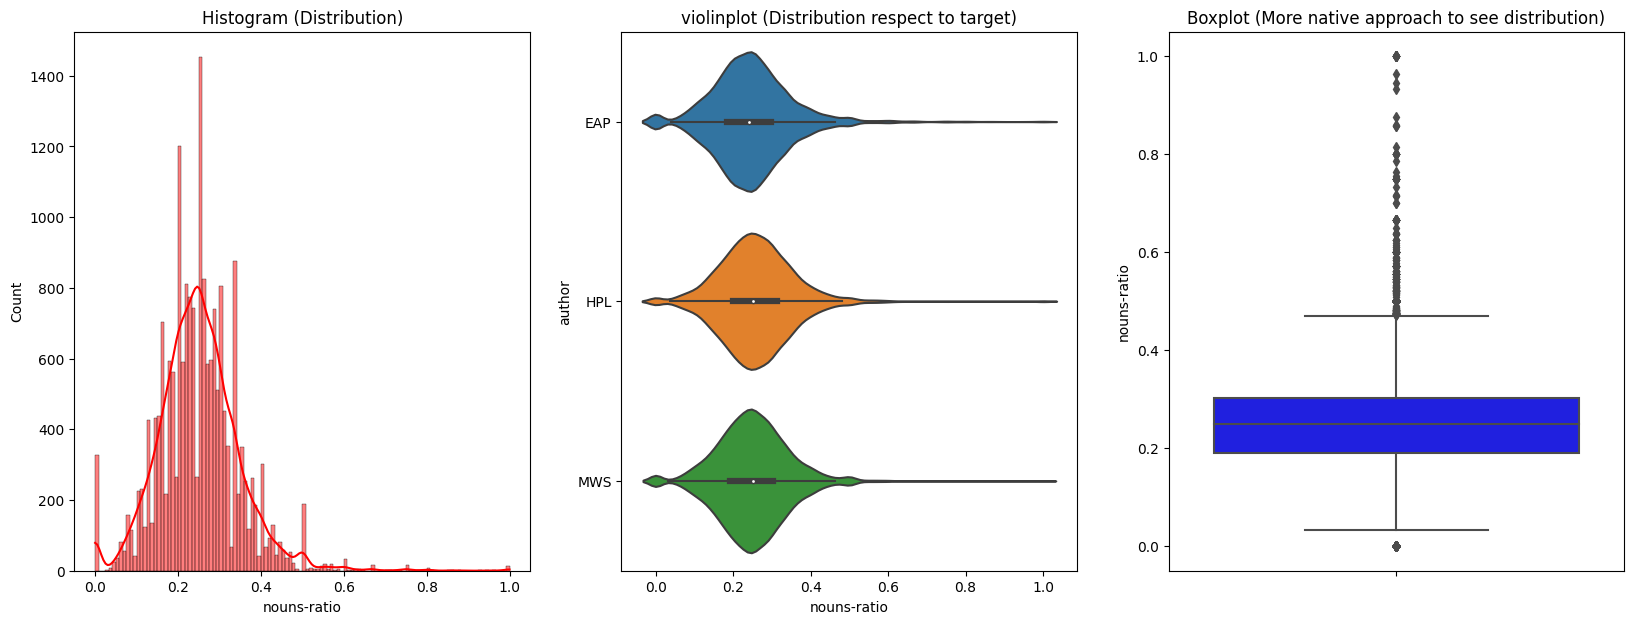

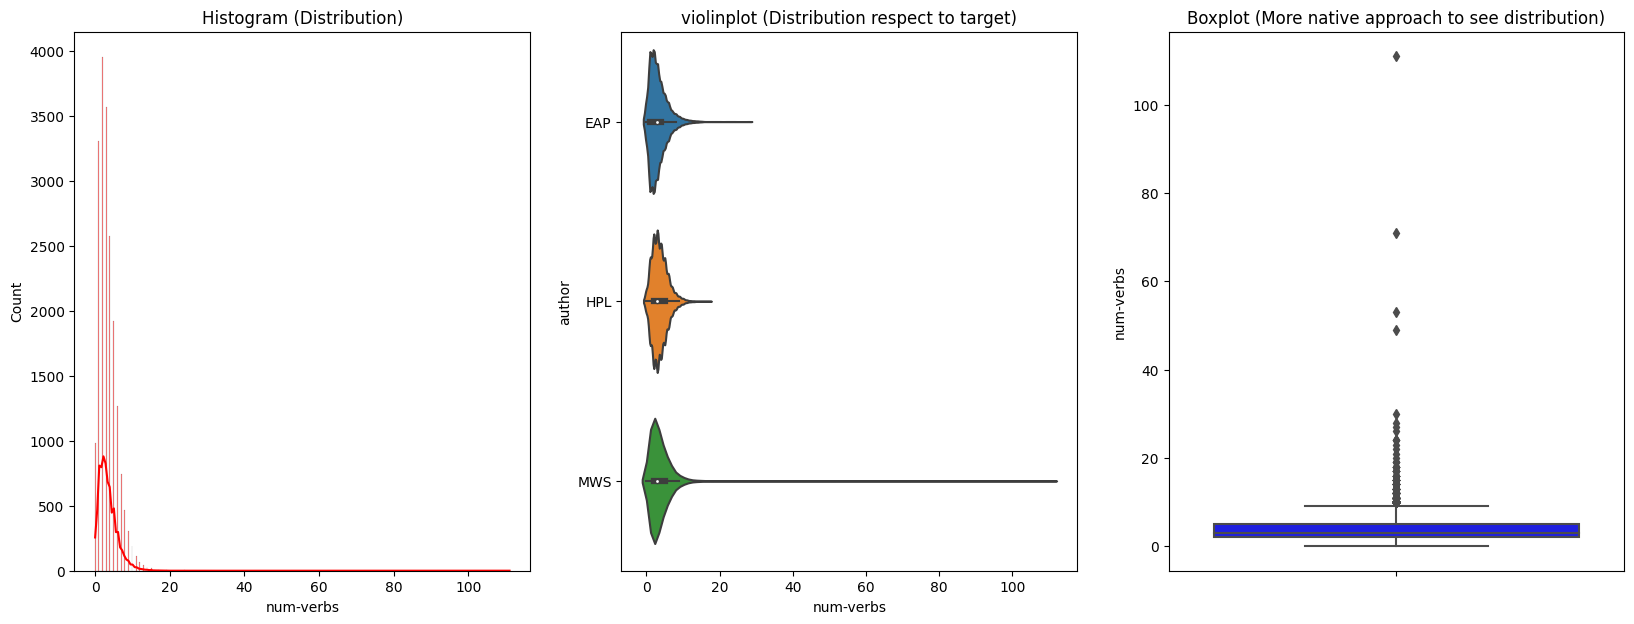

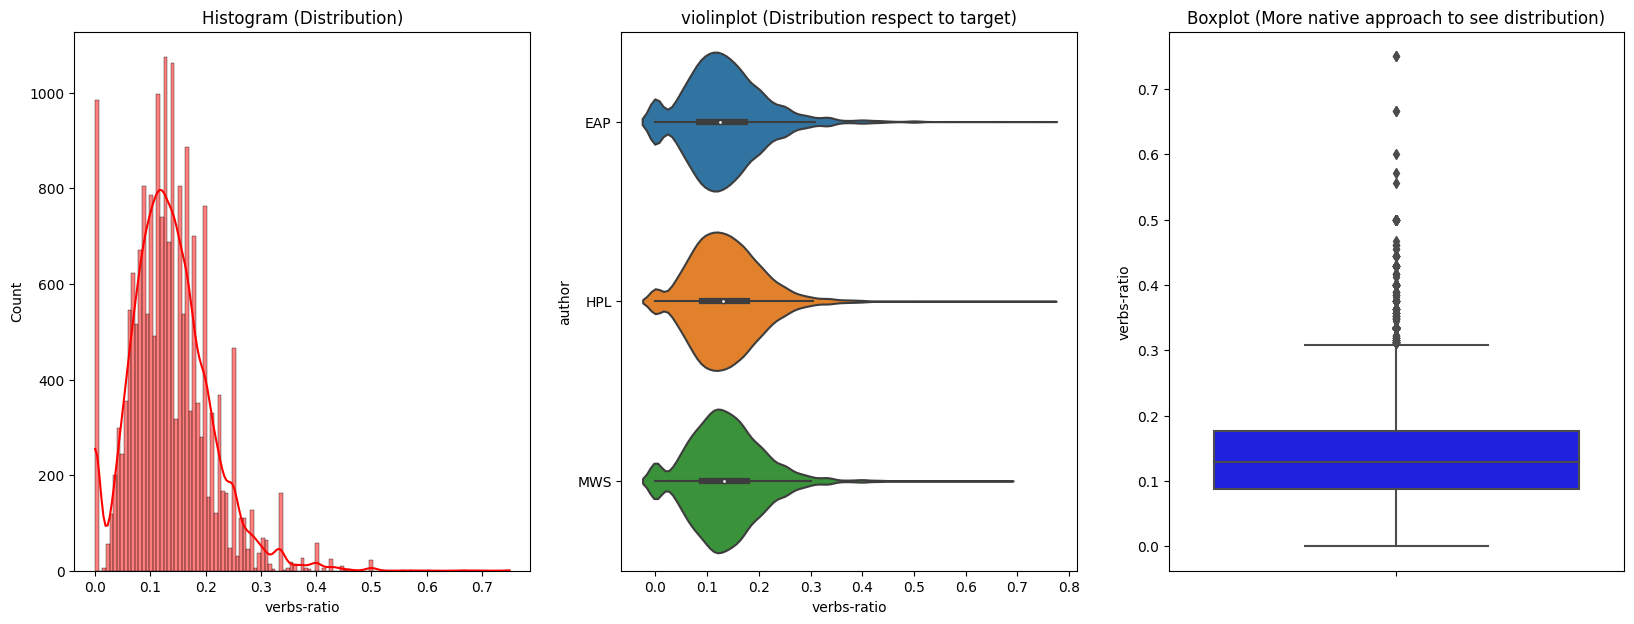

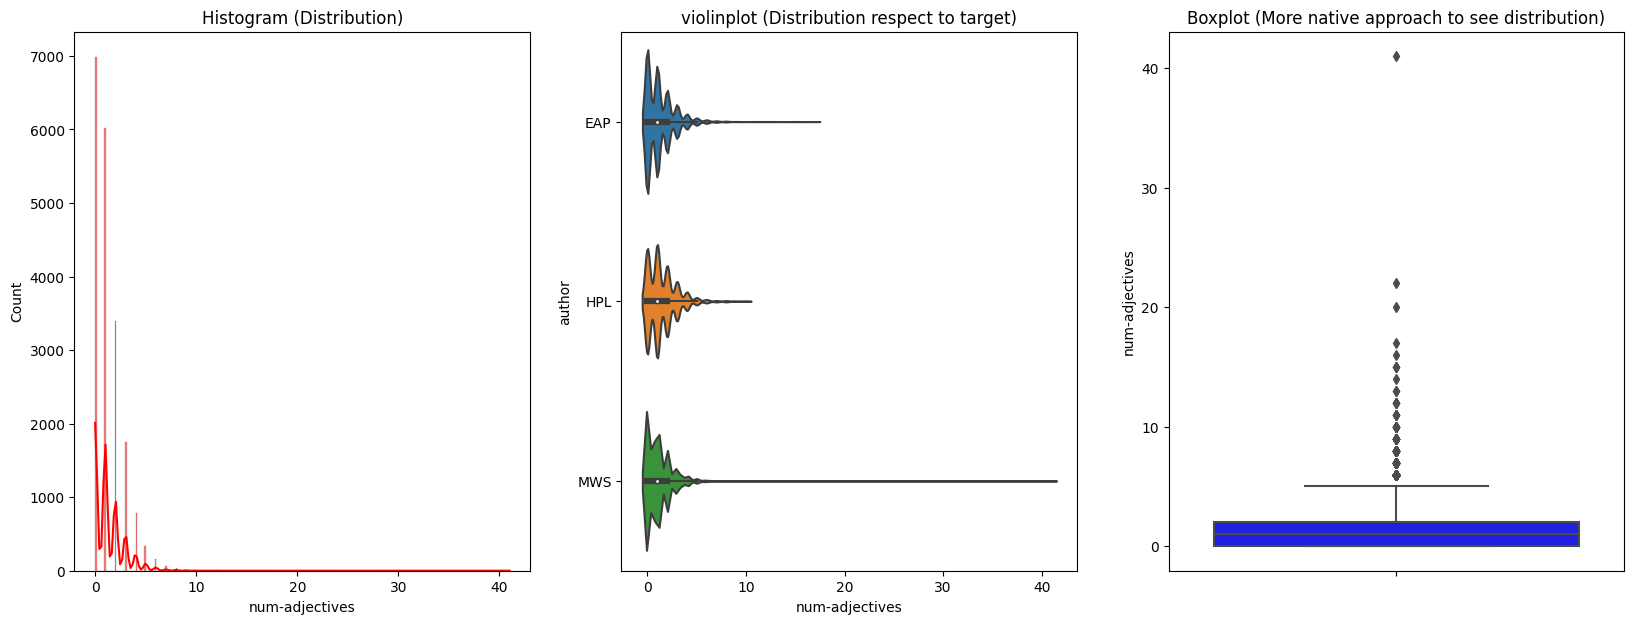

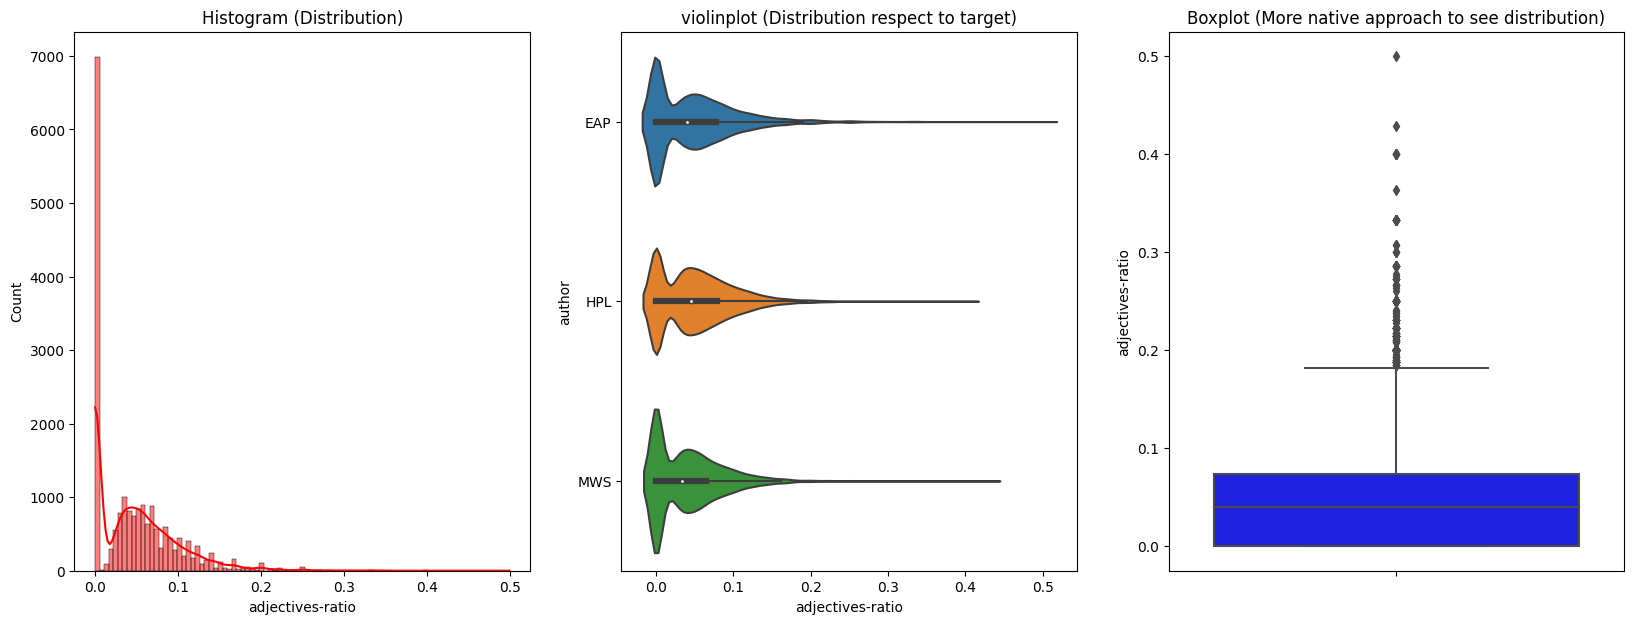

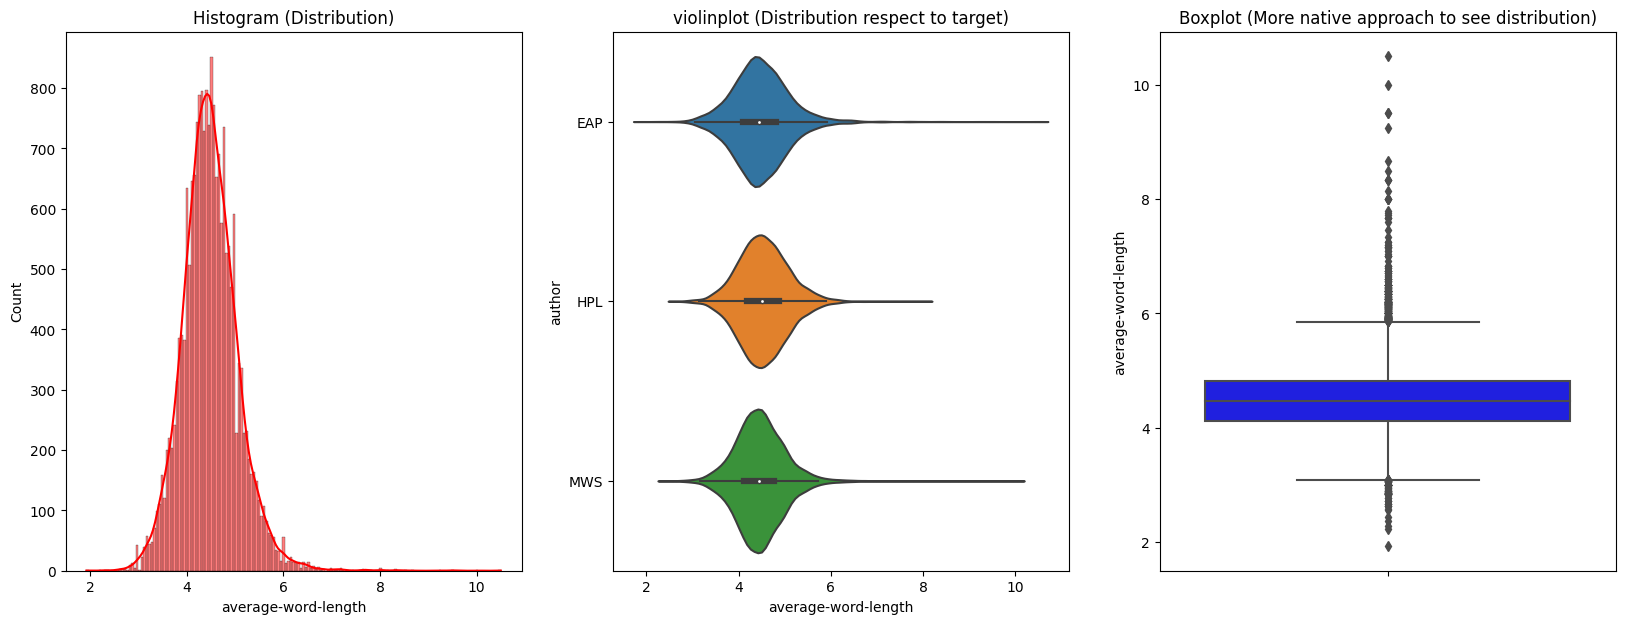

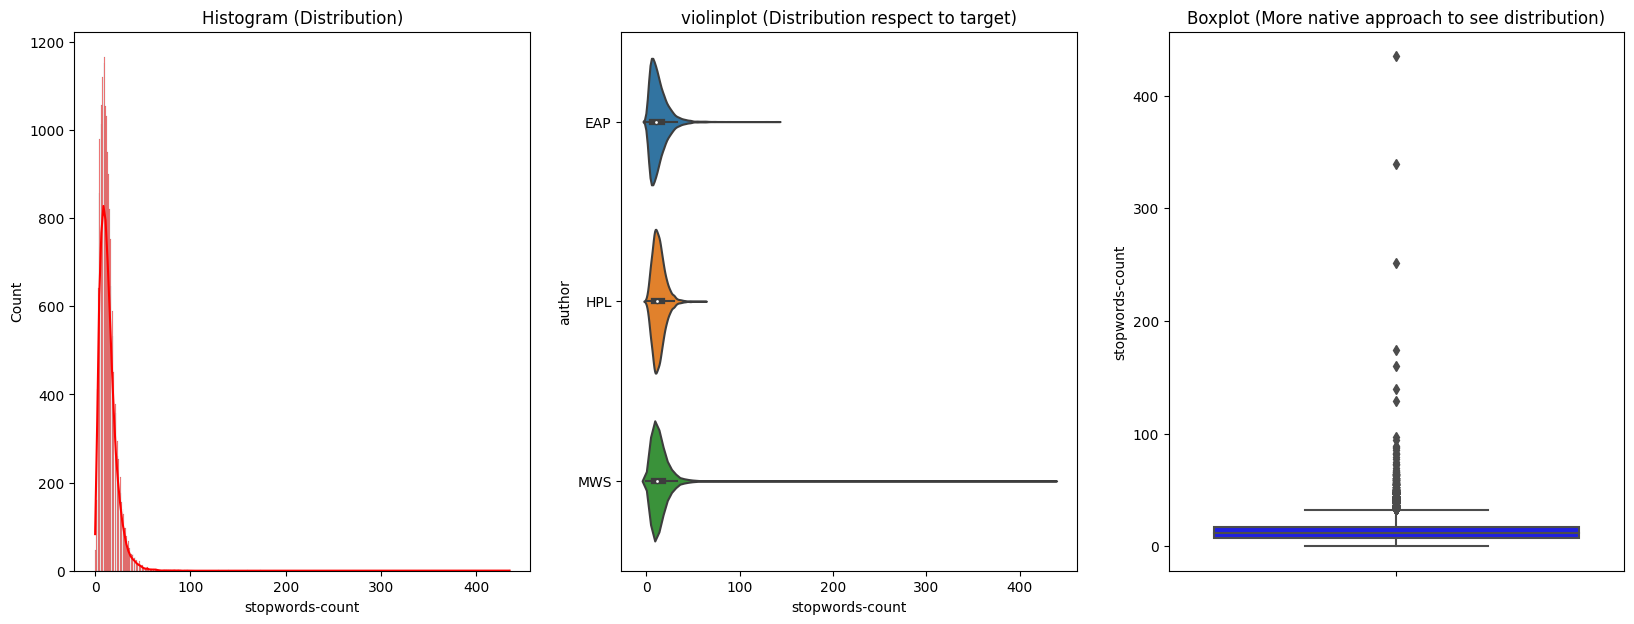

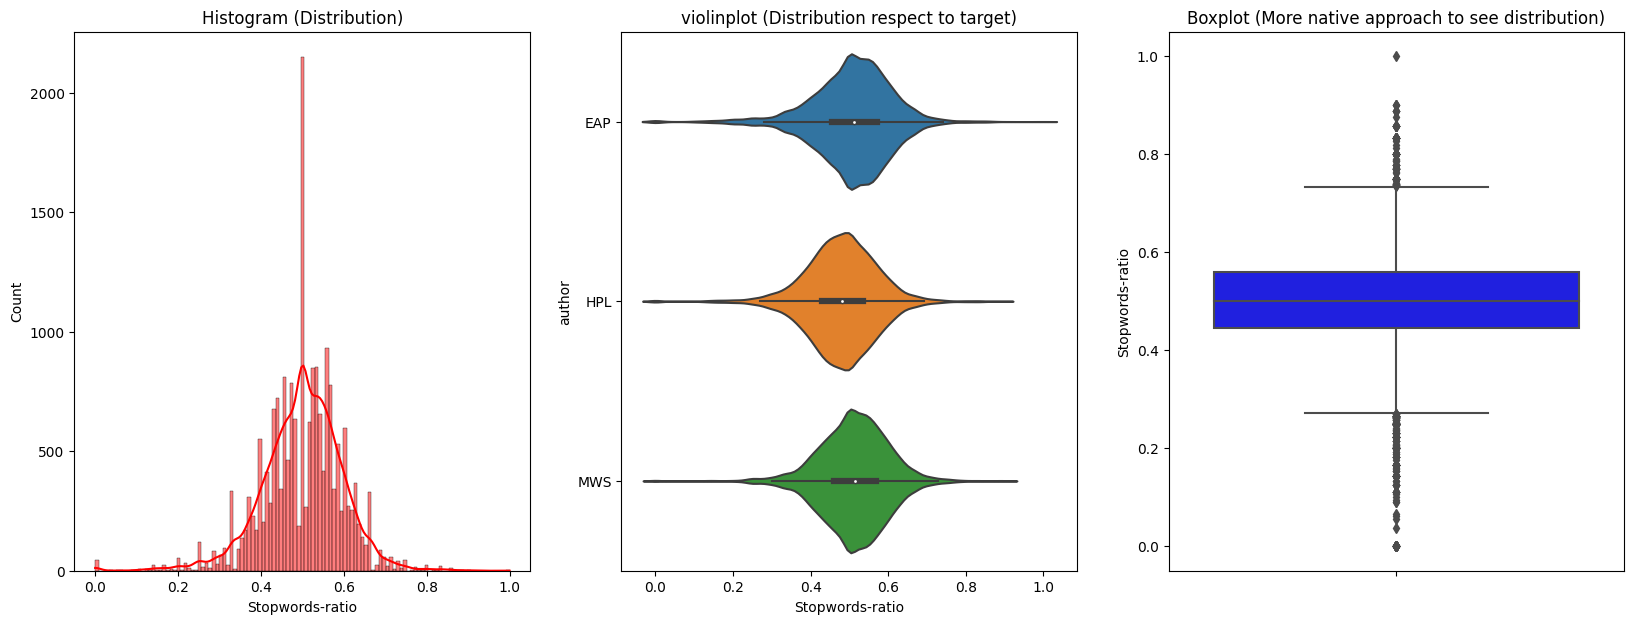

In [38]:
# Data by Data Visualization
#All the columns are continuous
# Continuous Variables
continuous_vars = []
for column, dtype in SpookyProcessedTrain_Simple.dtypes.items():
    if dtype in ['int64', 'float64']:
        continuous_vars.append(column)
#Evaluate Continuous Columns
for column in continuous_vars:
    describe_continuous_dataset(SpookyProcessedTrain_Simple, column)


- Number of Words might be useful to show average text length
- Sentence Length might be useful to show a few occurence that is really long (EAP has longer sentences)
- Num-words-beginning-capital might be useful (EAP is more focused on less capital words)
- Since number of words are already registered, I am using ratio (and discard the count attributes) so that the attributes are not skewed
- average word length and stopwords-ratio shows quite different violinplot graph between the three authors <br>
Now, I am going to throw away count attributes, if there is already ratio to avoid duplicate attribute extreme skewness

In [43]:
pickedSimpleAttributes = ['author', #target 
                          'num-words','unique-word-ratio','punctuation-ratio','sentence-length','num-words-beginning-capital','nouns-ratio','verbs-ratio','adjectives-ratio','average-word-length','Stopwords-ratio']

SpookyProcessedTrain_Simple_Selected = SpookyProcessedTrain_Simple[pickedSimpleAttributes]

# Model Creation

In [7]:
def scoringCalculations(dtree, Xdata, Ydata, model_name, context, n_splits=10):
    # since class is imbalanced, we use macro average
    y_pred = dtree.predict(Xdata)
    stratified_kfold = StratifiedKFold(n_splits=n_splits)
    print("====================================")
    if(context == "train"):
        cross_val_score_list = cross_val_score(dtree, Xdata, Ydata, cv=stratified_kfold, scoring='balanced_accuracy')
        print(f"{model_name}'s crossval(balanced_accuracy) score: {cross_val_score_list.mean()}, with values: {cross_val_score_list}")
    print(f"{model_name}'s {context} balanced accuracy: {balanced_accuracy_score(Ydata, y_pred)}")
    print(f"{model_name}'s {context} accuracy: {accuracy_score(Ydata, y_pred)}")
    print(f"{model_name}'s {context} precision: {precision_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} recall: {recall_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} f1 score: {f1_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} confusion matrix: ")
    print(confusion_matrix(Ydata, y_pred))
    print("=====================================")

In [57]:
model_name='All_EAP'
all1 = SpookyProcessedTrain_Simple_Selected['author'].copy()
for i in range(len(all1)):
    all1[i] = "EAP"
print("====================================")
print(f"{model_name}'s balanced accuracy: {balanced_accuracy_score(SpookyProcessedTrain_Simple_Selected['author'],all1)}")
print(f"{model_name}'s accuracy: {accuracy_score(SpookyProcessedTrain_Simple_Selected['author'],all1)}")
print(f"{model_name}'s precision: {precision_score(SpookyProcessedTrain_Simple_Selected['author'], all1, average='macro')}")
print(f"{model_name}'s recall: {recall_score(SpookyProcessedTrain_Simple_Selected['author'], all1, average='macro')}")
print(f"{model_name}'s f1 score: {f1_score(SpookyProcessedTrain_Simple_Selected['author'], all1, average='macro')}")
print(f"{model_name}'s confusion matrix: ")
print(confusion_matrix(SpookyProcessedTrain_Simple_Selected['author'], all1))
print("=====================================")

All_EAP's balanced accuracy: 0.3333333333333333
All_EAP's accuracy: 0.40349353899586293
All_EAP's precision: 0.1344978463319543
All_EAP's recall: 0.3333333333333333
All_EAP's f1 score: 0.1916615112146245
All_EAP's confusion matrix: 
[[7900    0    0]
 [5635    0    0]
 [6044    0    0]]


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline Models, only using Simple Attributes

In [58]:
baseline_model = tree.DecisionTreeClassifier(random_state=42)
x_train_all = SpookyProcessedTrain_Simple_Selected.drop('author', axis=1)
baseline_model.fit(x_train_all, SpookyProcessedTrain_Simple_Selected['author'])

#metrics
scoringCalculations(baseline_model, x_train_all, SpookyProcessedTrain_Simple_Selected['author'], "baseline", "train")

#Extremely Overfit

baseline's crossval(balanced_accuracy) score: 0.4131976004299031, with values: [0.42177122 0.40089602 0.4229171  0.40096421 0.41540137 0.41658967
 0.4022339  0.42136473 0.41383433 0.41600345]
baseline's train balanced accuracy: 0.9956080406576642
baseline's train accuracy: 0.9960161397415598
baseline's train precision: 0.9966041109924116
baseline's train recall: 0.9956080406576642
baseline's train f1 score: 0.99609395719202
baseline's train confusion matrix: 
[[7898    0    2]
 [  29 5606    0]
 [  41    6 5997]]


For the cross validation Balanced Accuracy is used to be more robust from imbalanced dataset compared to accuracy

In [69]:
# Cross Validation to try the best hyperparameters of tree
def optuna_hyperparameter_search_crossvalidation(XData, YData, n_splits):
    def objective(trial):
        # Define range of hyperparameters
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']) #evaluation criterion
        max_depth = trial.suggest_int('max_depth', 2, 256, log=True) #maximum depth of the tree, control overfitting
        #min_samples_split = trial.suggest_float('min_samples_split', 0.0, 1) #minimum number of samples (fraction) required to split an internal node
        #min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.0, 1) #minimum number of samples (fraction) required to be at a leaf node
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
        ccp_alpha = trial.suggest_float('ccp_alpha', 0, 0.1)  # You might want to adjust the range based on your data

        
        clf = tree.DecisionTreeClassifier(
            criterion=criterion,
            max_depth=max_depth,
            #min_samples_split=min_samples_split,
            #min_samples_leaf=min_samples_leaf, 
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            random_state=42)
        
        # Use stratified K-fold cross-validation
        stratified_kfold = StratifiedKFold(n_splits=n_splits)
        return cross_val_score(clf, XData, YData, cv=stratified_kfold, scoring='balanced_accuracy').mean()
    study = optuna.create_study(direction='maximize')  # 'maximize' because we're maximizing accuracy
    study.optimize(objective, n_trials=100)
    fig = optuna.visualization.plot_param_importances(study)
    # Print results
    print(f"The best hyperparameter value are {study.best_params} with a score of {study.best_value}.")
    fig.show()
    return study.best_value, study.best_params

def train_tree_using_best_optuna_result(XTrainData, YTrainData, model_name, optuna_results, n_splits=10):
    criterion = optuna_results['criterion']
    max_depth = optuna_results['max_depth']
    #min_samples_split = optuna_results['min_samples_split']
    #min_samples_leaf = optuna_results['min_samples_leaf']
    class_weight = optuna_results['class_weight']
    ccp_alpha = optuna_results['ccp_alpha']

    
    clf = tree.DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        #min_samples_split=min_samples_split,
        #min_samples_leaf=min_samples_leaf, 
        class_weight=class_weight,
        ccp_alpha=ccp_alpha,
        random_state=42)
    
    clf.fit(XTrainData, YTrainData)
    scoringCalculations(clf, XTrainData, YTrainData, model_name, "train", n_splits)
    

### Using all simple variables (not selected)

In [62]:
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'text', 'id'], axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_all, SpookyProcessedTrain_Simple['author'], 10)

[I 2023-10-23 20:32:06,018] A new study created in memory with name: no-name-59470e03-e971-448b-9e06-8452dd384438
[I 2023-10-23 20:32:06,462] Trial 0 finished with value: 0.33333333333333337 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'class_weight': None, 'ccp_alpha': 0.08642869670725556}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 20:32:07,101] Trial 1 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 6, 'class_weight': None, 'ccp_alpha': 0.022582520747865}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 20:32:07,578] Trial 2 finished with value: 0.33333333333333337 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'class_weight': 'balanced', 'ccp_alpha': 0.04403821776403033}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 20:32:08,337] Trial 3 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 8, 'class_weight': None, 'ccp_alpha':

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 9, 'class_weight': 'balanced', 'ccp_alpha': 0.0002909143522031939} with a score of 0.4779086631903344.


In [63]:
# Result are stuck at 0.47 balanced accuracy Cross validation
# Models are underfitting
optuna_results = {'criterion': 'gini', 'max_depth': 9, 'class_weight': 'balanced', 'ccp_alpha': 0.0002909143522031939}
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'text', 'id'], axis=1)
train_tree_using_best_optuna_result(x_train_all, SpookyProcessedTrain_Simple['author'], "Optuna with all Simple Traindata", optuna_results)

Optuna with all Simple Traindata's crossval(balanced_accuracy) score: 0.4779086631903344, with values: [0.48541211 0.48978696 0.46993464 0.45707333 0.49428838 0.47864202
 0.48729486 0.46733873 0.482373   0.46694259]
Optuna with all Simple Traindata's train balanced accuracy: 0.5088833859888243
Optuna with all Simple Traindata's train accuracy: 0.5062567036110118
Optuna with all Simple Traindata's train precision: 0.4985553431201936
Optuna with all Simple Traindata's train recall: 0.5088833859888243
Optuna with all Simple Traindata's train f1 score: 0.49854298641010325
Optuna with all Simple Traindata's train confusion matrix: 
[[4060 1834 2006]
 [1044 3705  886]
 [2013 1884 2147]]


### Using simple variables (selected)

In [64]:
x_train_selected = SpookyProcessedTrain_Simple_Selected.drop(['author'], axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_selected, SpookyProcessedTrain_Simple_Selected['author'], 10)

[I 2023-10-23 20:37:31,703] A new study created in memory with name: no-name-50be43e9-7e55-4013-8f3d-046e1fd15ae2
[I 2023-10-23 20:37:32,328] Trial 0 finished with value: 0.42131643834558935 and parameters: {'criterion': 'gini', 'max_depth': 7, 'class_weight': 'balanced', 'ccp_alpha': 0.0102476330909413}. Best is trial 0 with value: 0.42131643834558935.
[I 2023-10-23 20:37:33,633] Trial 1 finished with value: 0.33333333333333337 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'class_weight': 'balanced', 'ccp_alpha': 0.09023891433656493}. Best is trial 0 with value: 0.42131643834558935.
[I 2023-10-23 20:37:34,088] Trial 2 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 4, 'class_weight': 'balanced', 'ccp_alpha': 0.08754931250383793}. Best is trial 0 with value: 0.42131643834558935.
[I 2023-10-23 20:37:34,562] Trial 3 finished with value: 0.42227269376245735 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'class_weight': 'bal

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 14, 'class_weight': 'balanced', 'ccp_alpha': 0.0002609319549352558} with a score of 0.4762845714594685.


- Feature Selection actually makes the performance worse
- It is expected of Decision Tree, where it discards unused feature automatically

In [65]:
optuna_results = {'criterion': 'gini', 'max_depth': 14, 'class_weight': 'balanced', 'ccp_alpha': 0.0002609319549352558}
x_train_selected = SpookyProcessedTrain_Simple_Selected.drop(['author'], axis=1)
train_tree_using_best_optuna_result(x_train_selected, SpookyProcessedTrain_Simple_Selected['author'], "Optuna with selected Simple Traindata", optuna_results)

Optuna with selected Simple Traindata's crossval(balanced_accuracy) score: 0.4762845714594685, with values: [0.48903983 0.48607475 0.45942207 0.4712052  0.46643411 0.48418419
 0.47217251 0.46685014 0.49769133 0.46977159]
Optuna with selected Simple Traindata's train balanced accuracy: 0.5077460903687263
Optuna with selected Simple Traindata's train accuracy: 0.5025792941416825
Optuna with selected Simple Traindata's train precision: 0.5047918578161917
Optuna with selected Simple Traindata's train recall: 0.5077460903687263
Optuna with selected Simple Traindata's train f1 score: 0.5032138966186714
Optuna with selected Simple Traindata's train confusion matrix: 
[[3727 1461 2712]
 [ 954 3335 1346]
 [1735 1531 2778]]


### No Feature Discard + TFIDFSVD

In [68]:
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'text', 'id'], axis=1)
x_train_all_TFIDF_SVD_10 = pd.concat([x_train_all, SpookyProcessedTrain_TFIDF_SVD_10], axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_all_TFIDF_SVD_10, SpookyProcessedTrain_Simple['author'], 10)

[I 2023-10-23 20:44:14,194] A new study created in memory with name: no-name-623825c0-b83e-40b5-9bcb-54667f60e66e


[I 2023-10-23 20:44:15,471] Trial 0 finished with value: 0.44807038984330383 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'class_weight': None, 'ccp_alpha': 0.05673330679999357}. Best is trial 0 with value: 0.44807038984330383.
[I 2023-10-23 20:44:18,971] Trial 1 finished with value: 0.458810878890662 and parameters: {'criterion': 'gini', 'max_depth': 60, 'class_weight': None, 'ccp_alpha': 0.017998307147420435}. Best is trial 1 with value: 0.458810878890662.
[I 2023-10-23 20:44:22,668] Trial 2 finished with value: 0.531905215267477 and parameters: {'criterion': 'gini', 'max_depth': 175, 'class_weight': 'balanced', 'ccp_alpha': 0.004848531461871386}. Best is trial 2 with value: 0.531905215267477.
[I 2023-10-23 20:44:27,831] Trial 3 finished with value: 0.44807038984330383 and parameters: {'criterion': 'entropy', 'max_depth': 69, 'class_weight': None, 'ccp_alpha': 0.05148416624783761}. Best is trial 2 with value: 0.531905215267477.
[I 2023-10-23 20:44:31,295] Trial 4 finished

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 23, 'class_weight': 'balanced', 'ccp_alpha': 0.001056063236558845} with a score of 0.5761821737966798.


In [72]:
optuna_results = {'criterion': 'entropy', 'max_depth': 23, 'class_weight': 'balanced', 'ccp_alpha': 0.001056063236558845}
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'text', 'id'], axis=1)
x_train_all_TFIDF_SVD_10 = pd.concat([x_train_all, SpookyProcessedTrain_TFIDF_SVD_10], axis=1)
train_tree_using_best_optuna_result(x_train_all_TFIDF_SVD_10, SpookyProcessedTrain_Simple['author'], "Optuna with selected Simple Traindata", optuna_results)

Optuna with selected Simple Traindata's crossval(balanced_accuracy) score: 0.5761821737966798, with values: [0.58113642 0.58185737 0.56682117 0.57327359 0.56099349 0.58651792
 0.58422203 0.58880181 0.57152784 0.5666701 ]
Optuna with selected Simple Traindata's train balanced accuracy: 0.5952430394311244
Optuna with selected Simple Traindata's train accuracy: 0.5869554114101844
Optuna with selected Simple Traindata's train precision: 0.5877239105056926
Optuna with selected Simple Traindata's train recall: 0.5952430394311244
Optuna with selected Simple Traindata's train f1 score: 0.587533827265218
Optuna with selected Simple Traindata's train confusion matrix: 
[[4088 1889 1923]
 [1177 3601  857]
 [1092 1149 3803]]


In [74]:
# Model Accuracy Rises Greatly, Now try with various approach of TF-IDF
SVD_Components_List = [10,20,50,100,200,400,600,800]
resultSummarization = {}
scores = []
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'text', 'id'], axis=1)
for n_components in SVD_Components_List:
    looked_SVD = pd.read_csv(f'Data/spooky-author-identification/Train_processed_TFIDFSVD_{n_components}.csv')
    x_train_all_TFIDF_SVD = pd.concat([x_train_all, looked_SVD], axis=1)
    best_value, best_params = optuna_hyperparameter_search_crossvalidation(x_train_all_TFIDF_SVD, SpookyProcessedTrain_Simple['author'], 10)
    resultSummarization[n_components] = {'best_value': best_value, 'best_params': best_params}
    scores.append(best_value)
plt.plot(SVD_Components_List, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Balanced Accuracy Cross Validation')
plt.title('Balanced Accuracy Cross Validation vs. Number of Components')
plt.grid(True)
plt.show()

[I 2023-10-23 20:57:16,752] A new study created in memory with name: no-name-cf563400-85c5-4911-994c-29fea4cd02b9


[I 2023-10-23 20:57:20,147] Trial 0 finished with value: 0.5251226001674671 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'class_weight': None, 'ccp_alpha': 0.01655829744487244}. Best is trial 0 with value: 0.5251226001674671.
[I 2023-10-23 20:57:21,590] Trial 1 finished with value: 0.531905215267477 and parameters: {'criterion': 'gini', 'max_depth': 5, 'class_weight': 'balanced', 'ccp_alpha': 0.005293887454166569}. Best is trial 1 with value: 0.531905215267477.
[I 2023-10-23 20:57:26,918] Trial 2 finished with value: 0.5254370489031602 and parameters: {'criterion': 'entropy', 'max_depth': 98, 'class_weight': 'balanced', 'ccp_alpha': 0.02695414974427808}. Best is trial 1 with value: 0.531905215267477.
[I 2023-10-23 20:57:32,078] Trial 3 finished with value: 0.44807038984330383 and parameters: {'criterion': 'entropy', 'max_depth': 132, 'class_weight': None, 'ccp_alpha': 0.04935829403059655}. Best is trial 1 with value: 0.531905215267477.
[I 2023-10-23 20:57:33,203] Trial 4 fi

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 10, 'class_weight': 'balanced', 'ccp_alpha': 0.0008584746589652872} with a score of 0.5759167047263245.


[I 2023-10-23 21:02:34,004] A new study created in memory with name: no-name-26424d0a-5c00-4157-b3f3-baad80880069
[I 2023-10-23 21:02:35,398] Trial 0 finished with value: 0.5240199179892153 and parameters: {'criterion': 'gini', 'max_depth': 3, 'class_weight': None, 'ccp_alpha': 0.011335613563489933}. Best is trial 0 with value: 0.5240199179892153.
[I 2023-10-23 21:02:36,873] Trial 1 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 3, 'class_weight': 'balanced', 'ccp_alpha': 0.05788832177268945}. Best is trial 0 with value: 0.5240199179892153.
[I 2023-10-23 21:02:39,815] Trial 2 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 7, 'class_weight': 'balanced', 'ccp_alpha': 0.06538007351871085}. Best is trial 0 with value: 0.5240199179892153.
[I 2023-10-23 21:02:40,808] Trial 3 finished with value: 0.5240199179892153 and parameters: {'criterion': 'gini', 'max_depth': 2, 'class_weight': None, 'ccp_alpha': 0

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 8, 'class_weight': None, 'ccp_alpha': 0.0006447848711336362} with a score of 0.5663735665873165.


[I 2023-10-23 21:10:41,379] A new study created in memory with name: no-name-bc4f8f5f-27aa-4116-9739-89eeb11a03e6
[I 2023-10-23 21:10:46,057] Trial 0 finished with value: 0.5155050723863553 and parameters: {'criterion': 'gini', 'max_depth': 5, 'class_weight': 'balanced', 'ccp_alpha': 0.017236970323079647}. Best is trial 0 with value: 0.5155050723863553.
[I 2023-10-23 21:10:57,212] Trial 1 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 81, 'class_weight': 'balanced', 'ccp_alpha': 0.07451269510171984}. Best is trial 0 with value: 0.5155050723863553.
[I 2023-10-23 21:11:14,646] Trial 2 finished with value: 0.4618144624777232 and parameters: {'criterion': 'entropy', 'max_depth': 34, 'class_weight': 'balanced', 'ccp_alpha': 0.0587554516526304}. Best is trial 0 with value: 0.5155050723863553.
[I 2023-10-23 21:11:31,978] Trial 3 finished with value: 0.5220408556872504 and parameters: {'criterion': 'entropy', 'max_depth': 132, 'class_weight': 'balan

KeyboardInterrupt: 

In [75]:
#we see that increasing the components make the computation slower, but the score is not increasing
#we will stick with 10 components
print(resultSummarization)

{10: {'best_value': 0.5759167047263245, 'best_params': {'criterion': 'entropy', 'max_depth': 10, 'class_weight': 'balanced', 'ccp_alpha': 0.0008584746589652872}}, 20: {'best_value': 0.5663735665873165, 'best_params': {'criterion': 'entropy', 'max_depth': 8, 'class_weight': None, 'ccp_alpha': 0.0006447848711336362}}}


### No feature Discard + Spacy

In [78]:
#the 300 components calculation simply takes too long, so it won't be considered
SVD_Components_List = [5, 10, 20, 50]
resultSummarization = {}
scores = []
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'text', 'id'], axis=1)
for n_components in SVD_Components_List:
    if(n_components != 300):
        looked_SVD = pd.read_csv(f'Data/spooky-author-identification/Train_processed_SpacySVD_{n_components}.csv')
    else:
        looked_SVD = pd.read_csv(f'Data/spooky-author-identification/Train_processed_SpacySVD.csv')
    x_train_all_Spacy_SVD = pd.concat([x_train_all, looked_SVD], axis=1)
    best_value, best_params = optuna_hyperparameter_search_crossvalidation(x_train_all_Spacy_SVD, SpookyProcessedTrain_Simple['author'], 10)
    resultSummarization[n_components] = {'best_value': best_value, 'best_params': best_params}
    scores.append(best_value)
plt.plot(SVD_Components_List, explained_variances, marker='o')
plt.xlabel('Number of Components (Spacy)')
plt.ylabel('Balanced Accuracy Cross Validation')
plt.title('Balanced Accuracy Cross Validation vs. Number of Components')
plt.grid(True)
plt.show()

[I 2023-10-23 21:18:49,721] A new study created in memory with name: no-name-9a83b710-4ecf-48bd-aec8-dce9d428e359


[I 2023-10-23 21:18:52,557] Trial 0 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 35, 'class_weight': 'balanced', 'ccp_alpha': 0.02692344049095572}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 21:18:55,371] Trial 1 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 33, 'class_weight': 'balanced', 'ccp_alpha': 0.035216850134395176}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 21:18:59,383] Trial 2 finished with value: 0.33333333333333337 and parameters: {'criterion': 'entropy', 'max_depth': 133, 'class_weight': 'balanced', 'ccp_alpha': 0.051513815290231295}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 21:19:01,987] Trial 3 finished with value: 0.4106861059380386 and parameters: {'criterion': 'gini', 'max_depth': 128, 'class_weight': None, 'ccp_alpha': 0.015942417857898905}. Best is trial 3 with value: 0.4106861059380386.
[I 2023-10-23 21:19:05,9

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 9, 'class_weight': None, 'ccp_alpha': 0.000620969868735915} with a score of 0.4979004162688452.


[I 2023-10-23 21:23:13,166] A new study created in memory with name: no-name-2228569b-921f-4cf0-aba1-948b54e71e56
[I 2023-10-23 21:23:16,635] Trial 0 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 17, 'class_weight': 'balanced', 'ccp_alpha': 0.05853912959565566}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 21:23:22,113] Trial 1 finished with value: 0.4221002402437568 and parameters: {'criterion': 'entropy', 'max_depth': 39, 'class_weight': 'balanced', 'ccp_alpha': 0.017739113705675814}. Best is trial 1 with value: 0.4221002402437568.
[I 2023-10-23 21:23:26,763] Trial 2 finished with value: 0.33333333333333337 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'class_weight': 'balanced', 'ccp_alpha': 0.09557781749940047}. Best is trial 1 with value: 0.4221002402437568.
[I 2023-10-23 21:23:27,414] Trial 3 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 2, 'class_weight': Non

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 152, 'class_weight': 'balanced', 'ccp_alpha': 0.000863686392997603} with a score of 0.5231034743580539.


[I 2023-10-23 21:31:00,616] A new study created in memory with name: no-name-34c30444-943f-44d9-b734-64d5a26ec63b
[I 2023-10-23 21:31:08,177] Trial 0 finished with value: 0.33333333333333337 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'class_weight': 'balanced', 'ccp_alpha': 0.08774027219929026}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 21:31:10,878] Trial 1 finished with value: 0.4181436483414197 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'class_weight': None, 'ccp_alpha': 0.022142589946628558}. Best is trial 1 with value: 0.4181436483414197.
[I 2023-10-23 21:31:19,175] Trial 2 finished with value: 0.41411356215421324 and parameters: {'criterion': 'entropy', 'max_depth': 23, 'class_weight': None, 'ccp_alpha': 0.01653582330110136}. Best is trial 1 with value: 0.4181436483414197.
[I 2023-10-23 21:31:24,731] Trial 3 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 91, 'class_weight': 'balanced', 

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 162, 'class_weight': None, 'ccp_alpha': 0.0004329818135387692} with a score of 0.522275291071823.


[I 2023-10-23 21:41:15,755] A new study created in memory with name: no-name-4f066d8a-2df8-4a8b-ac19-e15662b1c8b4
[I 2023-10-23 21:41:27,071] Trial 0 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 43, 'class_weight': 'balanced', 'ccp_alpha': 0.03724940007025175}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 21:41:37,887] Trial 1 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 39, 'class_weight': None, 'ccp_alpha': 0.04808377057692692}. Best is trial 0 with value: 0.33333333333333337.
[I 2023-10-23 21:41:49,204] Trial 2 finished with value: 0.43376364145988333 and parameters: {'criterion': 'gini', 'max_depth': 221, 'class_weight': 'balanced', 'ccp_alpha': 0.0070905914078595485}. Best is trial 2 with value: 0.43376364145988333.
[I 2023-10-23 21:41:59,980] Trial 3 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 67, 'class_weight': None, 'cc

KeyboardInterrupt: 

Balanced Accuracy Stuck and does not increase much, as compared to TFIDF SVD

### Gathering the dataset for TF-IDF and Spacy

In [79]:
#We have seen that previously 10 TFIDF works best,
#while the Spacy SVD doesnt increase much, but 10 works best
#try gathering these two datas and try once more with optuna
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'text', 'id'], axis=1)
x_train_all_TFIDF_Spacy_SVD_10 = pd.concat([x_train_all, SpookyProcessedTrain_TFIDF_SVD_10, SpookyProcessedTrain_Spacy_SVD_10], axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_all_TFIDF_Spacy_SVD_10, SpookyProcessedTrain_Simple['author'], 10)

[I 2023-10-23 22:05:56,548] A new study created in memory with name: no-name-5b6f96ba-5f97-4618-9036-92d2c706d0cc
[I 2023-10-23 22:06:01,978] Trial 0 finished with value: 0.5325071397424715 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'class_weight': 'balanced', 'ccp_alpha': 0.00852928320166504}. Best is trial 0 with value: 0.5325071397424715.
[I 2023-10-23 22:06:09,958] Trial 1 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 11, 'class_weight': 'balanced', 'ccp_alpha': 0.0742630105462196}. Best is trial 0 with value: 0.5325071397424715.
[I 2023-10-23 22:06:20,073] Trial 2 finished with value: 0.5325071397424715 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'class_weight': 'balanced', 'ccp_alpha': 0.008476492462835527}. Best is trial 0 with value: 0.5325071397424715.
[I 2023-10-23 22:06:26,172] Trial 3 finished with value: 0.33333333333333337 and parameters: {'criterion': 'gini', 'max_depth': 8, 'class_weight': None, 'c

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 34, 'class_weight': None, 'ccp_alpha': 0.0003759571379081814} with a score of 0.5687604335566642.


### Trying TF-IDF with Multinomial bayes as a replacement for SVD

In [9]:
# Custom transformer to get the predictions from Multinomial Naive Bayes
class TFIDF_MNBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, tfidf, mnb):
        self.tfidf = tfidf
        self.mnb = mnb
    def fit(self, X, y):
        # Using the first two columns for Multinomial Naive Bayes
        X_mnb = X["text"]
        self.tfidf.fit(X_mnb)
        result_tfidf = self.tfidf.transform(X_mnb)
        self.mnb.fit(result_tfidf, y)
        return self
    
    def transform(self, X):
        X_mnb = X["text"]
        X_mnb_1 = self.tfidf.transform(X_mnb)
        return self.mnb.predict_proba(X_mnb_1)

# Custom transformer to pass through the data for Decision Tree
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self,  X, y=None):
        return self
    
    def transform(self, X):
        # Using the last two columns for Decision Tree
        return X.drop(['text'], axis=1)

In [99]:
# Make a new model with optuna, that stacks Multinomial bayes and Decision Tree
# Cross Validation to try the best hyperparameters of tree
def optuna_hyperparameter_search_crossvalidation_stack_Multinomialbayes(XData, YData, n_splits):
    def objective(trial):
        # Define range of hyperparameters
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']) #evaluation criterion
        max_depth = trial.suggest_int('max_depth', 2, 256, log=True) #maximum depth of the tree, control overfitting
        #min_samples_split = trial.suggest_float('min_samples_split', 0.0, 1) #minimum number of samples (fraction) required to split an internal node
        #min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.0, 1) #minimum number of samples (fraction) required to be at a leaf node
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
        ccp_alpha = trial.suggest_float('ccp_alpha', 0, 0.1)  # You might want to adjust the range based on your data

        mnb = naive_bayes.MultinomialNB()
        tfidf_transformer = TfidfVectorizer(stop_words = "english")
        # Define the pipeline
        pipeline = Pipeline([
            ('features', FeatureUnion([
                ('passthrough', PassthroughTransformer()),  # Passing the simple data
                ('mnb', TFIDF_MNBTransformer(tfidf_transformer, mnb)),  # Multinomial Naive Bayes output
            ])),
            ('dt', tree.DecisionTreeClassifier(random_state=42, criterion=criterion,
                    max_depth=max_depth,
                    #min_samples_split=min_samples_split,
                    #min_samples_leaf=min_samples_leaf, 
                    class_weight=class_weight,
                    ccp_alpha=ccp_alpha))  # Decision Tree classifier
        ])

        # 10-fold cross-validation
        cv = StratifiedKFold(n_splits=n_splits)
        return cross_val_score(pipeline, XData, YData, cv=cv, scoring='balanced_accuracy').mean()
    
    study = optuna.create_study(direction='maximize')  # 'maximize' because we're maximizing accuracy
    study.optimize(objective, n_trials=100)
    fig = optuna.visualization.plot_param_importances(study)
    # Print results
    print(f"The best hyperparameter value are {study.best_params} with a score of {study.best_value}.")
    fig.show()
    return study.best_value, study.best_params

In [100]:
x_train_all_with_text = SpookyProcessedTrain_Simple.drop(['author', 'id'], axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation_stack_Multinomialbayes(x_train_all_with_text, SpookyProcessedTrain_Simple['author'], 10)

[I 2023-10-24 00:05:36,124] A new study created in memory with name: no-name-d9a0d833-e0f9-4f3a-aa94-56d6b8c3f88a
[I 2023-10-24 00:05:46,399] Trial 0 finished with value: 0.8183693354566927 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'class_weight': None, 'ccp_alpha': 0.0926644847238421}. Best is trial 0 with value: 0.8183693354566927.
[I 2023-10-24 00:05:56,241] Trial 1 finished with value: 0.8152563676948805 and parameters: {'criterion': 'gini', 'max_depth': 220, 'class_weight': None, 'ccp_alpha': 0.038317146636931004}. Best is trial 0 with value: 0.8183693354566927.
[I 2023-10-24 00:06:04,647] Trial 2 finished with value: 0.8227825753243769 and parameters: {'criterion': 'gini', 'max_depth': 3, 'class_weight': 'balanced', 'ccp_alpha': 0.03676134255253615}. Best is trial 2 with value: 0.8227825753243769.
[I 2023-10-24 00:06:14,097] Trial 3 finished with value: 0.8183693354566927 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'class_weight': None, 'ccp_alpha': 

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 7, 'class_weight': 'balanced', 'ccp_alpha': 0.0003551585208215785} with a score of 0.8257511340700964.


In [101]:
def train_tree_stackedwith_TFIDF_MNB_using_best_optuna_result(XTrainData, YTrainData, model_name, optuna_results, n_splits=10):
    criterion = optuna_results['criterion']
    max_depth = optuna_results['max_depth']
    #min_samples_split = optuna_results['min_samples_split']
    #min_samples_leaf = optuna_results['min_samples_leaf']
    class_weight = optuna_results['class_weight']
    ccp_alpha = optuna_results['ccp_alpha']

    
    mnb = naive_bayes.MultinomialNB()
    tfidf_transformer = TfidfVectorizer(stop_words = "english")
    # Define the pipeline
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('passthrough', PassthroughTransformer()),  # Passing the simple data
            ('mnb', TFIDF_MNBTransformer(tfidf_transformer, mnb)),  # Multinomial Naive Bayes output
        ])),
        ('dt', tree.DecisionTreeClassifier(random_state=42, criterion=criterion,
                max_depth=max_depth,
                #min_samples_split=min_samples_split,
                #min_samples_leaf=min_samples_leaf, 
                class_weight=class_weight,
                ccp_alpha=ccp_alpha))  # Decision Tree classifier
    ])
    
    pipeline.fit(XTrainData, YTrainData)
    scoringCalculations(pipeline, XTrainData, YTrainData, model_name, "train", n_splits)

In [ ]:
optuna_results = {'criterion': 'gini', 'max_depth': 9, 'class_weight': 'balanced', 'ccp_alpha': 0.0002909143522031939}
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'id'], axis=1)
train_tree_using_best_optuna_result(x_train_all, SpookyProcessedTrain_Simple['author'], "Optuna with all Decision Tree + Minimum Naive bayes", optuna_results)

# Conclusion Approach

Best Model (If Model Stacking is Allowed): All Simple Text Extraction features + Feed text to TF-IDF and Multinomial bayes<br>

Hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'class_weight': 'balanced', 'ccp_alpha': 0.0003551585208215785}

Best Model's crossval(balanced_accuracy) score: 0.8257511340700964, with values: [0.82080298 0.81515979 0.82109957 0.83219185 0.83204182 0.82063315
 0.83394696 0.83171864 0.82664288 0.8232737 ]
Best Model's train balanced accuracy: 0.9247596335764268
Best Model's train accuracy: 0.9227233260125645
Best Model's train precision: 0.9221815079745571
Best Model's train recall: 0.9247596335764268
Best Model's train f1 score: 0.923180331686769
Best Model's train confusion matrix: 
[[7143  275  482]
 [ 220 5234  181]
 [ 258   97 5689]]
{'ccp_alpha': 0.0003551585208215785, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


[Text(0.5, 0.9, 'EAP_MNB <= 0.316\nentropy = 1.585\nsamples = 19579\nvalue = [6526.333, 6526.333, 6526.333]\nclass = EAP'),
 Text(0.25, 0.7, 'HPL_MNB <= 0.369\nentropy = 1.166\nsamples = 13679\nvalue = [6193.408, 391.464, 6310.373]\nclass = MWS'),
 Text(0.125, 0.5, 'Stopwords-ratio <= 0.596\nentropy = 0.528\nsamples = 7458\nvalue = [5739.043, 272.172, 298.026]\nclass = EAP'),
 Text(0.0625, 0.3, 'Stopwords-ratio <= 0.493\nentropy = 1.181\nsamples = 1606\nvalue = [1005.386, 192.258, 240.796]\nclass = EAP'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'EAP_MNB <= 0.168\nentropy = 0.213\nsamples = 5852\nvalue = [4733.657, 79.914, 57.23]\nclass = EAP'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'Stopwords-ratio <= 0.345\nentropy = 0.491\nsamples = 6221\nvalue = [454.365, 119.292, 6012.347]\nclass = MWS'),
 Text(0.3125, 0.3, 'HPL_MNB <= 0.655\nentropy = 0.254\nsamples = 5136\nvalue = [91.69

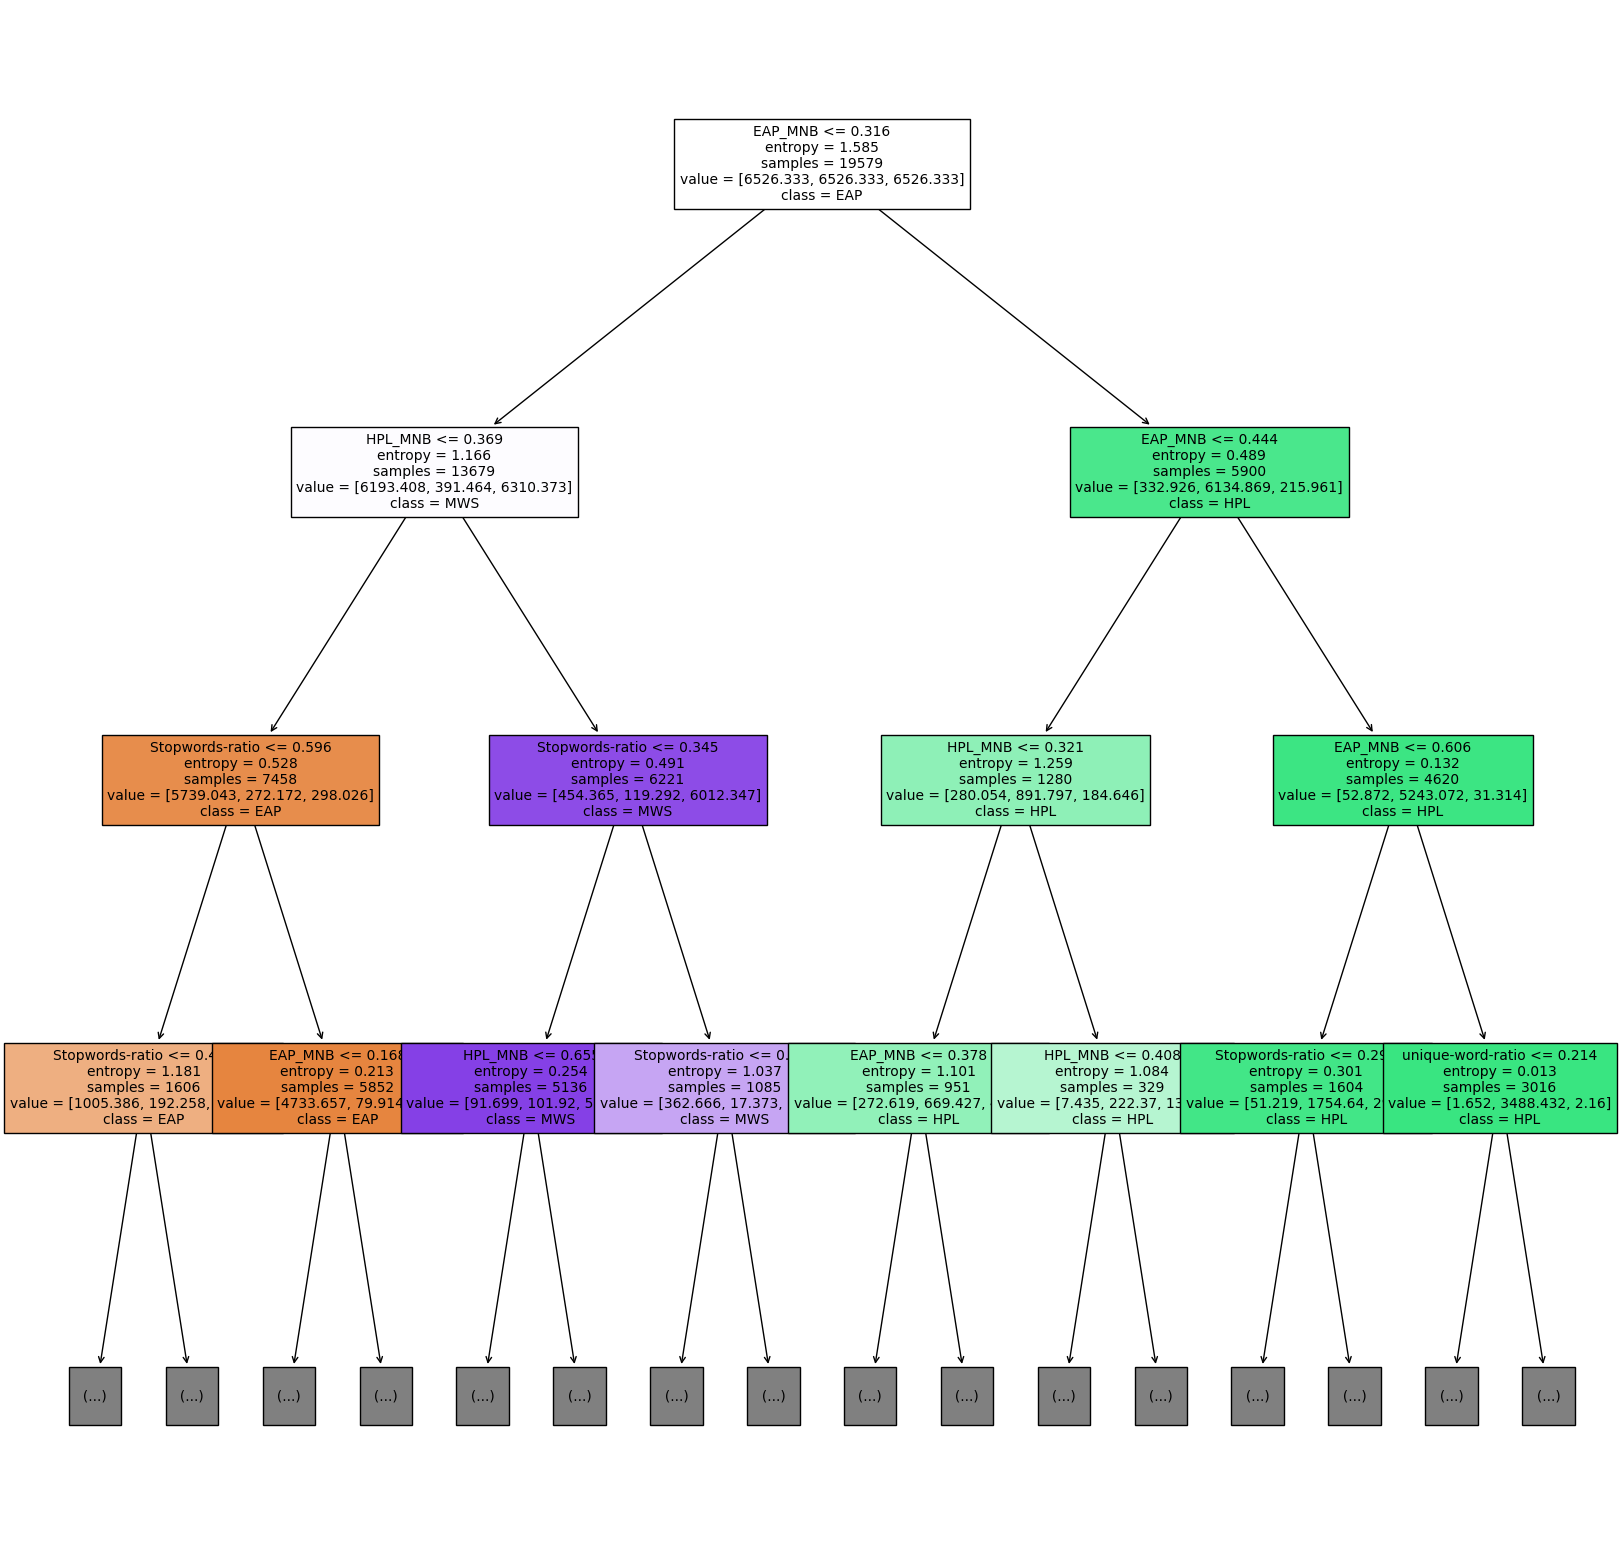

In [12]:
optuna_results = {'criterion': 'entropy', 'max_depth': 7, 'class_weight': 'balanced', 'ccp_alpha': 0.0003551585208215785}
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'id'], axis=1)
criterion = optuna_results['criterion']
max_depth = optuna_results['max_depth']
class_weight = optuna_results['class_weight']
ccp_alpha = optuna_results['ccp_alpha']

mnb = naive_bayes.MultinomialNB()
tfidf_transformer = TfidfVectorizer(stop_words = "english")
# Define the pipeline
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('passthrough', PassthroughTransformer()),  # Passing the simple data
        ('mnb', TFIDF_MNBTransformer(tfidf_transformer, mnb)),  # Multinomial Naive Bayes output
    ])),
    ('dt', tree.DecisionTreeClassifier(random_state=42, criterion=criterion,
            max_depth=max_depth,
            #min_samples_split=min_samples_split,
            #min_samples_leaf=min_samples_leaf, 
            class_weight=class_weight,
            ccp_alpha=ccp_alpha))  # Decision Tree classifier
])

pipeline.fit(x_train_all, SpookyProcessedTrain_Simple['author'])
scoringCalculations(pipeline, x_train_all, SpookyProcessedTrain_Simple['author'], "Best Model", "train", n_splits=10)

#draw top 4 level of the tree
plt.figure(figsize=(20,20))
print(pipeline.named_steps['dt'].get_params())
tree.plot_tree(pipeline.named_steps['dt'], filled=True, feature_names=list(x_train_all.columns)+  ["EAP_MNB", "HPL_MNB", "MWS_MNB"], class_names=['EAP', 'HPL', 'MWS'], max_depth=3, fontsize=10)

Best Model (Without Model Stacking): All Simple Text Extraction + Feed Text to TF-IDF, and Execute SVD to 10 components.<br>

Hyperparameters: {'criterion': 'entropy', 'max_depth': 23, 'class_weight': 'balanced', 'ccp_alpha': 0.001056063236558845}

Best Model's crossval(balanced_accuracy) score: 0.5761821737966798, with values: [0.58113642 0.58185737 0.56682117 0.57327359 0.56099349 0.58651792
 0.58422203 0.58880181 0.57152784 0.5666701 ]
Best Model's train balanced accuracy: 0.5952430394311244
Best Model's train accuracy: 0.5869554114101844
Best Model's train precision: 0.5877239105056926
Best Model's train recall: 0.5952430394311244
Best Model's train f1 score: 0.587533827265218
Best Model's train confusion matrix: 
[[4088 1889 1923]
 [1177 3601  857]
 [1092 1149 3803]]
{'ccp_alpha': 0.001056063236558845, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 23, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


[Text(0.5, 0.9, 'TF-IDF-TSVD_6 <= -0.003\nentropy = 1.585\nsamples = 19579\nvalue = [6526.333, 6526.333, 6526.333]\nclass = EAP'),
 Text(0.25, 0.7, 'TF-IDF-TSVD_8 <= 0.0\nentropy = 1.462\nsamples = 8478\nvalue = [2315.609, 1723.369, 4521.138]\nclass = MWS'),
 Text(0.125, 0.5, 'TF-IDF-TSVD_6 <= -0.013\nentropy = 1.337\nsamples = 5139\nvalue = [1167.305, 844.312, 3236.172]\nclass = MWS'),
 Text(0.0625, 0.3, 'TF-IDF-TSVD_3 <= -0.017\nentropy = 1.178\nsamples = 3186\nvalue = [574.152, 416.944, 2301.062]\nclass = MWS'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'TF-IDF-TSVD_4 <= 0.006\nentropy = 1.51\nsamples = 1953\nvalue = [593.153, 427.368, 935.11]\nclass = MWS'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'TF-IDF-TSVD_6 <= -0.038\nentropy = 1.568\nsamples = 3339\nvalue = [1148.304, 879.057, 1284.966]\nclass = MWS'),
 Text(0.3125, 0.3, 'TF-IDF-TSVD_8 <= 0.044\nentropy = 1.305\nsamples 

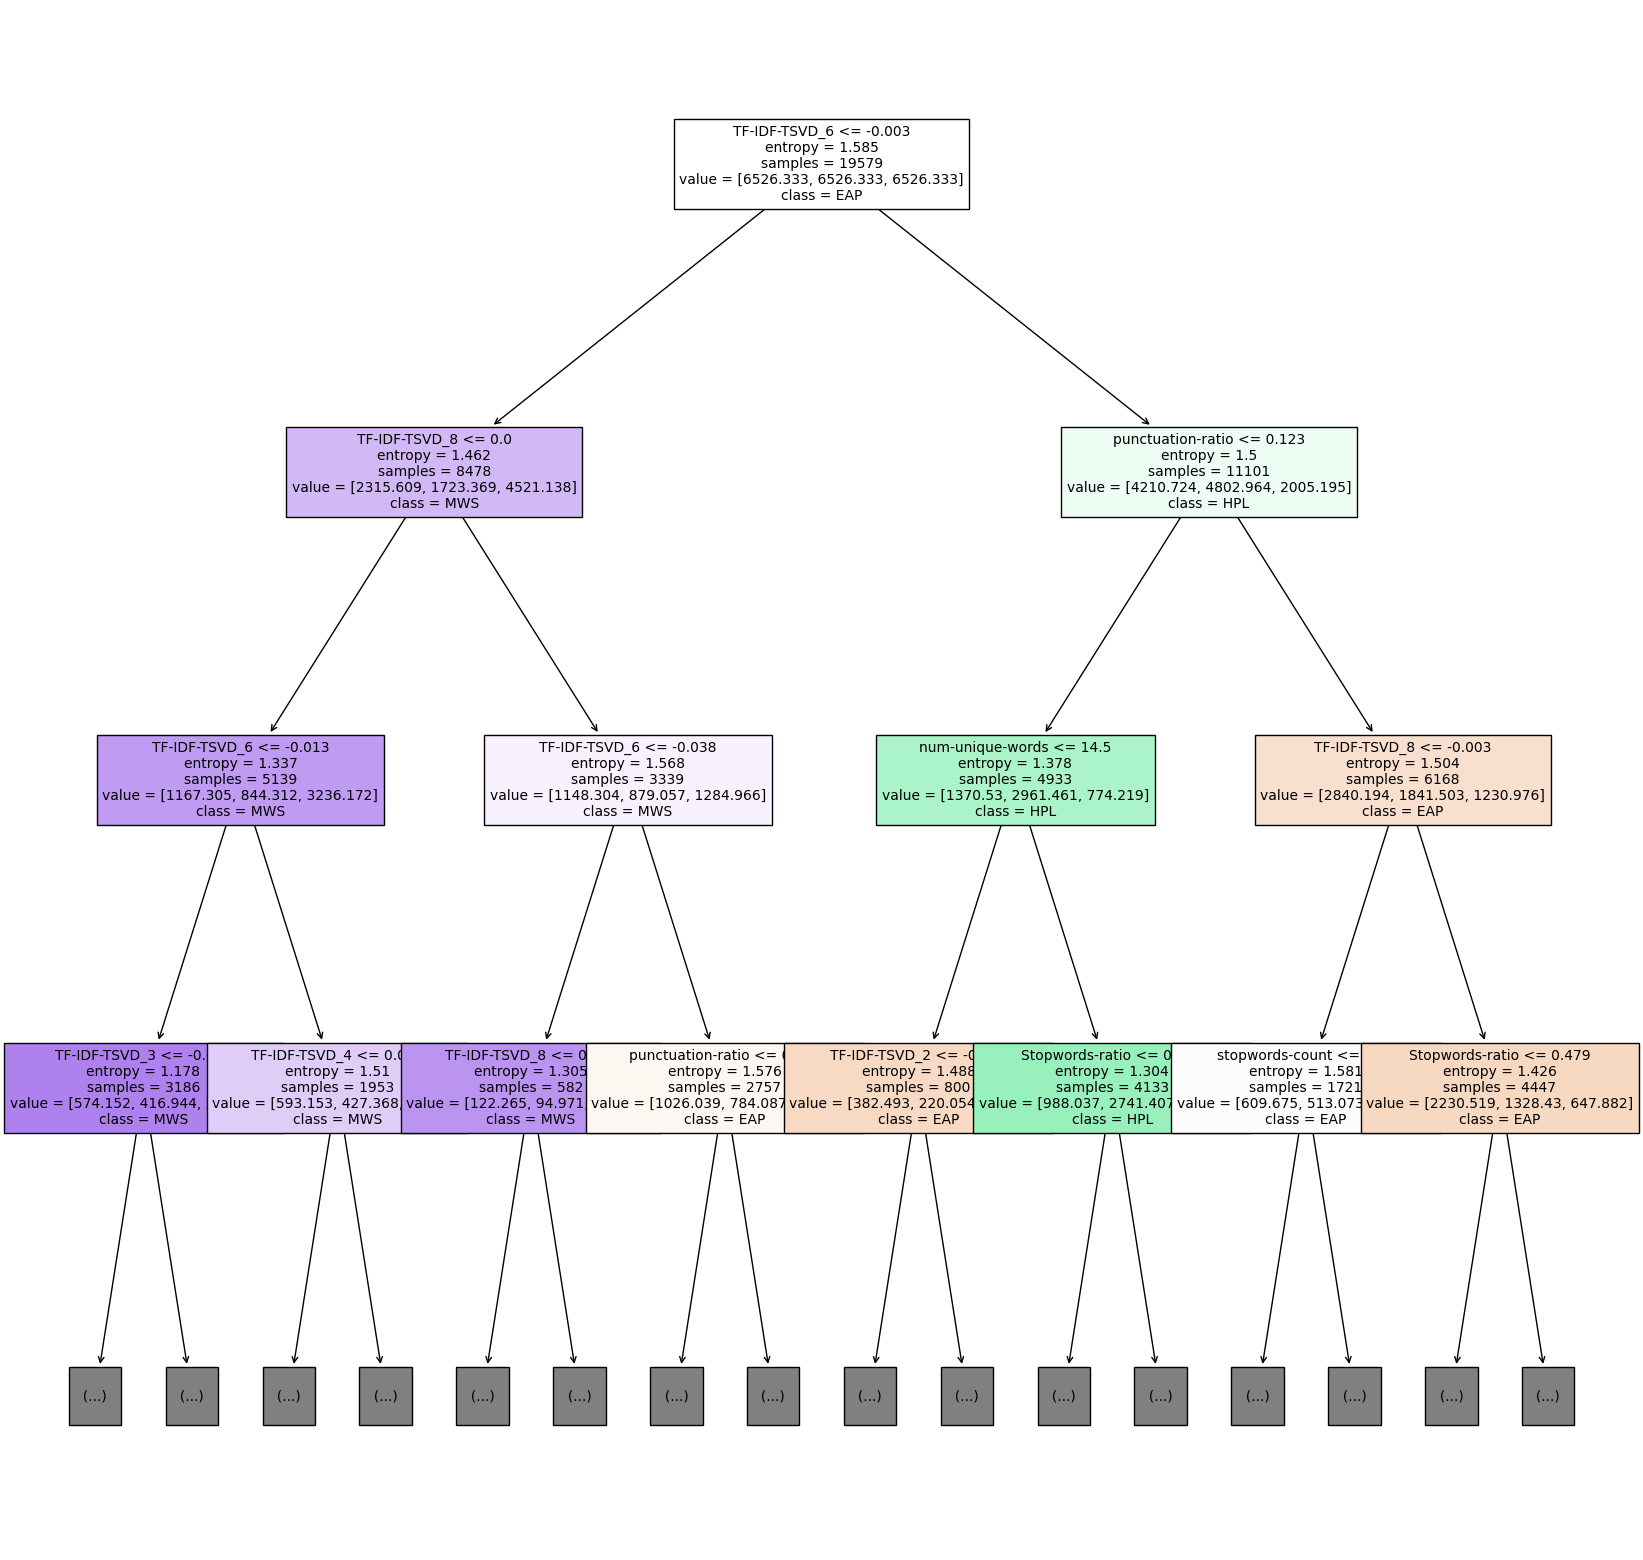

In [14]:
optuna_results = {'criterion': 'entropy', 'max_depth': 23, 'class_weight': 'balanced', 'ccp_alpha': 0.001056063236558845}
x_train_all = SpookyProcessedTrain_Simple.drop(['author', 'text', 'id'], axis=1)
x_train_all_TFIDF_SVD_10 = pd.concat([x_train_all, SpookyProcessedTrain_TFIDF_SVD_10], axis=1)
criterion = optuna_results['criterion']
max_depth = optuna_results['max_depth']
class_weight = optuna_results['class_weight']
ccp_alpha = optuna_results['ccp_alpha']


clf = tree.DecisionTreeClassifier(
    criterion=criterion,
    max_depth=max_depth,
    class_weight=class_weight,
    ccp_alpha=ccp_alpha,
    random_state=42)

clf.fit(x_train_all_TFIDF_SVD_10, SpookyProcessedTrain_Simple['author'])
scoringCalculations(clf, x_train_all_TFIDF_SVD_10, SpookyProcessedTrain_Simple['author'], "Best Model", "train", n_splits=10)

#draw top 4 level of the tree
plt.figure(figsize=(20,20))
print(clf.get_params())
tree.plot_tree(clf, filled=True, feature_names=x_train_all_TFIDF_SVD_10.columns, class_names=['EAP', 'HPL', 'MWS'], max_depth=3, fontsize=10)